# Info
Purpose:

    ACCDAM project to look into the trends for GOME, MOPITT, OMI, and TOMS (O3, NO2, CO)

Input:

    None

Output:

    Figure and save files

Keywords:

    none

Dependencies:

    - load_utils.py
    - matplotlib
    - numpy
    - write_utils
    - path_utils
    - hdf5storage
    - scipy

Needed Files:
  - file.rc : for consistent creation of look of matplotlib figures
  - L3 

Modification History:

    Written: Samuel LeBlanc, Santa Cruz, CA, 2023-02-08
    Modified:


# Prepare python environment

In [30]:
import numpy as np
import load_utils as lu
import write_utils as wu
from path_utils import getpath
import hdf5storage as hs
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib notebook
import os
import pandas as pd
from datetime import datetime 

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
name = 'ACCDAM'
vv = 'v1'
fp = getpath(name)


Return path named:  ACCDAM /data/sam/ACCDAM_2023/


Notes on the seasonal decomposition  


from https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html  

Notes  

This is a naive decomposition. More sophisticated methods should be preferred.  

The additive model is Y[t] = T[t] + S[t] + e[t]  

The multiplicative model is Y[t] = T[t] * S[t] * e[t]  

The results are obtained by first estimating the trend by applying a convolution filter to the data. The trend is then removed from the series and the average of this de-trended series for each period is the returned seasonal component.  

# Load files

Load the different L3 files  
Send from Matt Johnson on Jan 25th, 2023

## Load GOME Tropos NO2

In [11]:
gome,gome_dict = lu.load_netcdf(fp+'GOME_SCIAMACHY_GOME2_NO2_L3/GOME_SCIAMACHY_GOME2ab_TroposNO2_v2.3_041996-092017_temis.nc',everything=True)

Reading file: /data/sam/ACCDAM_2023/GOME_SCIAMACHY_GOME2_NO2_L3/GOME_SCIAMACHY_GOME2ab_TroposNO2_v2.3_041996-092017_temis.nc
Outputting the Data subdatasets:
0: lon
1: lat
2: time
3: TroposNO2
[b'lon', b'lat', b'time', b'TroposNO2']


In [28]:
for k in gome: 
    print(k,gome[k].shape)

b'lon' (1440,)
b'lat' (720,)
b'time' (258,)
b'TroposNO2' (258, 720, 1440)


In [14]:
gome[b'lon']

masked_array(data=[-179.875, -179.625, -179.375, ...,  179.375,  179.625,
                    179.875],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [15]:
gome[b'time']

masked_array(data=[199604.5, 199605.5, 199606.5, 199607.5, 199608.5,
                   199609.5, 199610.5, 199611.5, 199612.5, 199701.5,
                   199702.5, 199703.5, 199704.5, 199705.5, 199706.5,
                   199707.5, 199708.5, 199709.5, 199710.5, 199711.5,
                   199712.5, 199801.5, 199802.5, 199803.5, 199804.5,
                   199805.5, 199806.5, 199807.5, 199808.5, 199809.5,
                   199810.5, 199811.5, 199812.5, 199901.5, 199902.5,
                   199903.5, 199904.5, 199905.5, 199906.5, 199907.5,
                   199908.5, 199909.5, 199910.5, 199911.5, 199912.5,
                   200001.5, 200002.5, 200003.5, 200004.5, 200005.5,
                   200006.5, 200007.5, 200008.5, 200009.5, 200010.5,
                   200011.5, 200012.5, 200101.5, 200102.5, 200103.5,
                   200104.5, 200105.5, 200106.5, 200107.5, 200108.5,
                   200109.5, 200110.5, 200111.5, 200112.5, 200201.5,
                   200202.5, 20020

In [17]:
gome[b'TroposNO2'].mean()

0.44576338835303614

In [44]:
gometime = [datetime((t/100.0).astype(int),(((t/100.0)%1)*100.0).astype(int),15) for t in gome[b'time']]

### Convert GOME time series to pandas time for one point to start

Beijing: 39.9042° N, 116.4074° E  
San Francisco: 37.7749° N, 122.4194° W

In [21]:
points = {'Beijing':{'lon':116.40,'lat':39.9},
          'San Francisco': {'lon':-122.42,'lat':37.77}}

In [26]:
ilon = np.argmin(np.abs(gome[b'lon']-points['Beijing']['lon']))
ilat = np.argmin(np.abs(gome[b'lat']-points['Beijing']['lat']))
ilon,ilat

(1185, 519)

In [48]:
gome_NO2_pd = pd.DataFrame(data=gome[b'TroposNO2'][:,ilat,ilon])
gome_NO2_pd['time'] = pd.to_datetime(gometime)
gome_NO2_pd['trop_NO2'] = gome[b'TroposNO2'][:,ilat,ilon]
gome_NO2_pd.set_index('time', inplace = True)
gome_NO2_pd.dropna(inplace=True)

In [52]:
gno2 = gome_NO2_pd.resample('M').mean()
gno2.interpolate(inplace=True)

## Load MOPITT
Should have 235 files

In [62]:
fp

'/data/sam/ACCDAM_2023/'

In [74]:
fp_mol = os.listdir(fp+'MOPITT/')
fp_mo = [f for f in fp_mol if '.he5' in f]
fp_mo.sort()

In [75]:
fp_mo

['MOP03TM-200003-L3V95.6.1.he5',
 'MOP03TM-200004-L3V95.6.1.he5',
 'MOP03TM-200005-L3V95.6.1.he5',
 'MOP03TM-200006-L3V95.6.1.he5',
 'MOP03TM-200007-L3V95.6.1.he5',
 'MOP03TM-200008-L3V95.6.1.he5',
 'MOP03TM-200009-L3V95.6.1.he5',
 'MOP03TM-200010-L3V95.6.1.he5',
 'MOP03TM-200011-L3V95.6.1.he5',
 'MOP03TM-200012-L3V95.6.1.he5',
 'MOP03TM-200101-L3V95.6.1.he5',
 'MOP03TM-200102-L3V95.6.1.he5',
 'MOP03TM-200103-L3V95.6.1.he5',
 'MOP03TM-200104-L3V95.6.1.he5',
 'MOP03TM-200105-L3V95.6.1.he5',
 'MOP03TM-200108-L3V95.6.1.he5',
 'MOP03TM-200109-L3V95.6.1.he5',
 'MOP03TM-200110-L3V95.6.1.he5',
 'MOP03TM-200111-L3V95.6.1.he5',
 'MOP03TM-200112-L3V95.6.1.he5',
 'MOP03TM-200201-L3V95.6.1.he5',
 'MOP03TM-200202-L3V95.6.1.he5',
 'MOP03TM-200203-L3V95.6.1.he5',
 'MOP03TM-200204-L3V95.6.1.he5',
 'MOP03TM-200205-L3V95.6.1.he5',
 'MOP03TM-200206-L3V95.6.1.he5',
 'MOP03TM-200207-L3V95.6.1.he5',
 'MOP03TM-200208-L3V95.6.1.he5',
 'MOP03TM-200209-L3V95.6.1.he5',
 'MOP03TM-200210-L3V95.6.1.he5',
 'MOP03TM-

In [133]:
mops,mop_dicts = [],[]
for f in fp_mo:
    print('Opening file: ', f)
    mop,mop_dict = lu.load_hdf(fp+'MOPITT/'+f,values=(('COday',20),('COnight',23)),verbose=False)
    mops.append(mop)
    mop_dicts.append(mop_dict)

Opening file:  MOP03TM-200003-L3V95.6.1.he5
Opening file:  MOP03TM-200004-L3V95.6.1.he5
Opening file:  MOP03TM-200005-L3V95.6.1.he5
Opening file:  MOP03TM-200006-L3V95.6.1.he5
Opening file:  MOP03TM-200007-L3V95.6.1.he5
Opening file:  MOP03TM-200008-L3V95.6.1.he5
Opening file:  MOP03TM-200009-L3V95.6.1.he5
Opening file:  MOP03TM-200010-L3V95.6.1.he5
Opening file:  MOP03TM-200011-L3V95.6.1.he5
Opening file:  MOP03TM-200012-L3V95.6.1.he5
Opening file:  MOP03TM-200101-L3V95.6.1.he5
Opening file:  MOP03TM-200102-L3V95.6.1.he5
Opening file:  MOP03TM-200103-L3V95.6.1.he5
Opening file:  MOP03TM-200104-L3V95.6.1.he5
Opening file:  MOP03TM-200105-L3V95.6.1.he5
Opening file:  MOP03TM-200108-L3V95.6.1.he5
Opening file:  MOP03TM-200109-L3V95.6.1.he5
Opening file:  MOP03TM-200110-L3V95.6.1.he5
Opening file:  MOP03TM-200111-L3V95.6.1.he5
Opening file:  MOP03TM-200112-L3V95.6.1.he5
Opening file:  MOP03TM-200201-L3V95.6.1.he5
Opening file:  MOP03TM-200202-L3V95.6.1.he5
Opening file:  MOP03TM-200203-L3

Opening file:  MOP03TM-201602-L3V95.6.1.he5
Opening file:  MOP03TM-201603-L3V95.6.1.he5
Opening file:  MOP03TM-201604-L3V95.6.1.he5
Opening file:  MOP03TM-201605-L3V95.6.1.he5
Opening file:  MOP03TM-201606-L3V95.6.1.he5
Opening file:  MOP03TM-201607-L3V95.6.1.he5
Opening file:  MOP03TM-201608-L3V95.6.1.he5
Opening file:  MOP03TM-201609-L3V95.6.1.he5
Opening file:  MOP03TM-201610-L3V95.6.1.he5
Opening file:  MOP03TM-201611-L3V95.6.1.he5
Opening file:  MOP03TM-201612-L3V95.6.1.he5
Opening file:  MOP03TM-201701-L3V95.6.1.he5
Opening file:  MOP03TM-201702-L3V95.6.1.he5
Opening file:  MOP03TM-201703-L3V95.6.1.he5
Opening file:  MOP03TM-201704-L3V95.6.1.he5
Opening file:  MOP03TM-201705-L3V95.6.1.he5
Opening file:  MOP03TM-201706-L3V95.6.1.he5
Opening file:  MOP03TM-201707-L3V95.6.1.he5
Opening file:  MOP03TM-201708-L3V95.6.1.he5
Opening file:  MOP03TM-201709-L3V95.6.1.he5
Opening file:  MOP03TM-201710-L3V95.6.1.he5
Opening file:  MOP03TM-201711-L3V95.6.1.he5
Opening file:  MOP03TM-201712-L3

In [130]:
import h5py
f5 = h5py.File(fp+'MOPITT/'+f)
mop_lat = list(f5['HDFEOS']['GRIDS']['MOP03']['Data Fields']['Latitude'])
mop_lon = list(f5['HDFEOS']['GRIDS']['MOP03']['Data Fields']['Longitude'])
mop_pre = list(f5['HDFEOS']['GRIDS']['MOP03']['Data Fields']['Pressure'])

In [80]:
mop_dict

{'//HDFEOS/GRIDS/MOP03/Data_Fields/APrioriCOMixingRatioProfileDay': {'HDFEOS_ADDITIONAL_FILE_ATTRIBUTES_FillValue': '-9999 ',
  'HDFEOS_ADDITIONAL_FILE_ATTRIBUTES_institution': 'MOPITT at ACOM of NCAR',
  'HDFEOS_ADDITIONAL_FILE_ATTRIBUTES_StartTime': '849312036.405999 ',
  'HDFEOS_ADDITIONAL_FILE_ATTRIBUTES_StopTime': '851990396.842999 ',
  'HDFEOS_ADDITIONAL_FILE_ATTRIBUTES_title': 'MOPITT Level 3 Monthly File',
  'HDFEOS_INFORMATION_HDFEOSVersion': 'HDFEOS_5.1.16'},
 '//HDFEOS/GRIDS/MOP03/Data_Fields/APrioriCOMixingRatioProfileNight': {'HDFEOS_ADDITIONAL_FILE_ATTRIBUTES_FillValue': '-9999 ',
  'HDFEOS_ADDITIONAL_FILE_ATTRIBUTES_institution': 'MOPITT at ACOM of NCAR',
  'HDFEOS_ADDITIONAL_FILE_ATTRIBUTES_StartTime': '849312036.405999 ',
  'HDFEOS_ADDITIONAL_FILE_ATTRIBUTES_StopTime': '851990396.842999 ',
  'HDFEOS_ADDITIONAL_FILE_ATTRIBUTES_title': 'MOPITT Level 3 Monthly File',
  'HDFEOS_INFORMATION_HDFEOSVersion': 'HDFEOS_5.1.16'},
 '//HDFEOS/GRIDS/MOP03/Data_Fields/APrioriCOSurfac

# Set the different regions

From Matt Johnson on 8 février 2023 11:51  

Hi Sam,

 

Here are the lat/lon bounds we discussed on our meeting today.  I’ve cc’d others from the project which will be interested in this.  I have taken a first pass on defining lat/lon bounds for the regions of: Southeast Asia, China, South Asia, Siberia, and trop Pacific Ocean.  The first three I used HTAP countries to define these bounds.  This is preliminary but at least we can start looking at O3, NO2, and CO trends from the satellite data.  We can easily adjust the lat/lon bounds based on future discussions.

 

Regions based on HTAP2 countries:  
Southeast Asia: 12°S–18°N, 95–140°E  
China: 21–46°N, 75–127°E  
South Asia: 6°N–31°N, 67–91°E  
Regions not based off HTAP2:  
Siberia: 50–75°N, 70–180°E  
Tropical Pacific Ocean: 5–35°N, 180–130°W  

US regions from proposal:  
 

|     | Color in Fig. 2 | Lat (°N) | Lon (°W) |  
| --- | --------------- | -------- | -------- |  
|Entire Domain | Base Map | 25 – 55 | 130 – 90 |  
|Coastal | Teal | 32 – 55 | 130 – 113 |  
| Northwest NA| Purple | 48 – 54 | 130 - 115 |
| Northern California | Orange | 35 – 41 | 126 – 120 | 
| Southern California | Olive Green | 35 – 32 | 120 – 113 | 
| Great Basin | Pink | 36 – 41 | 120 – 115 | 

   
   
   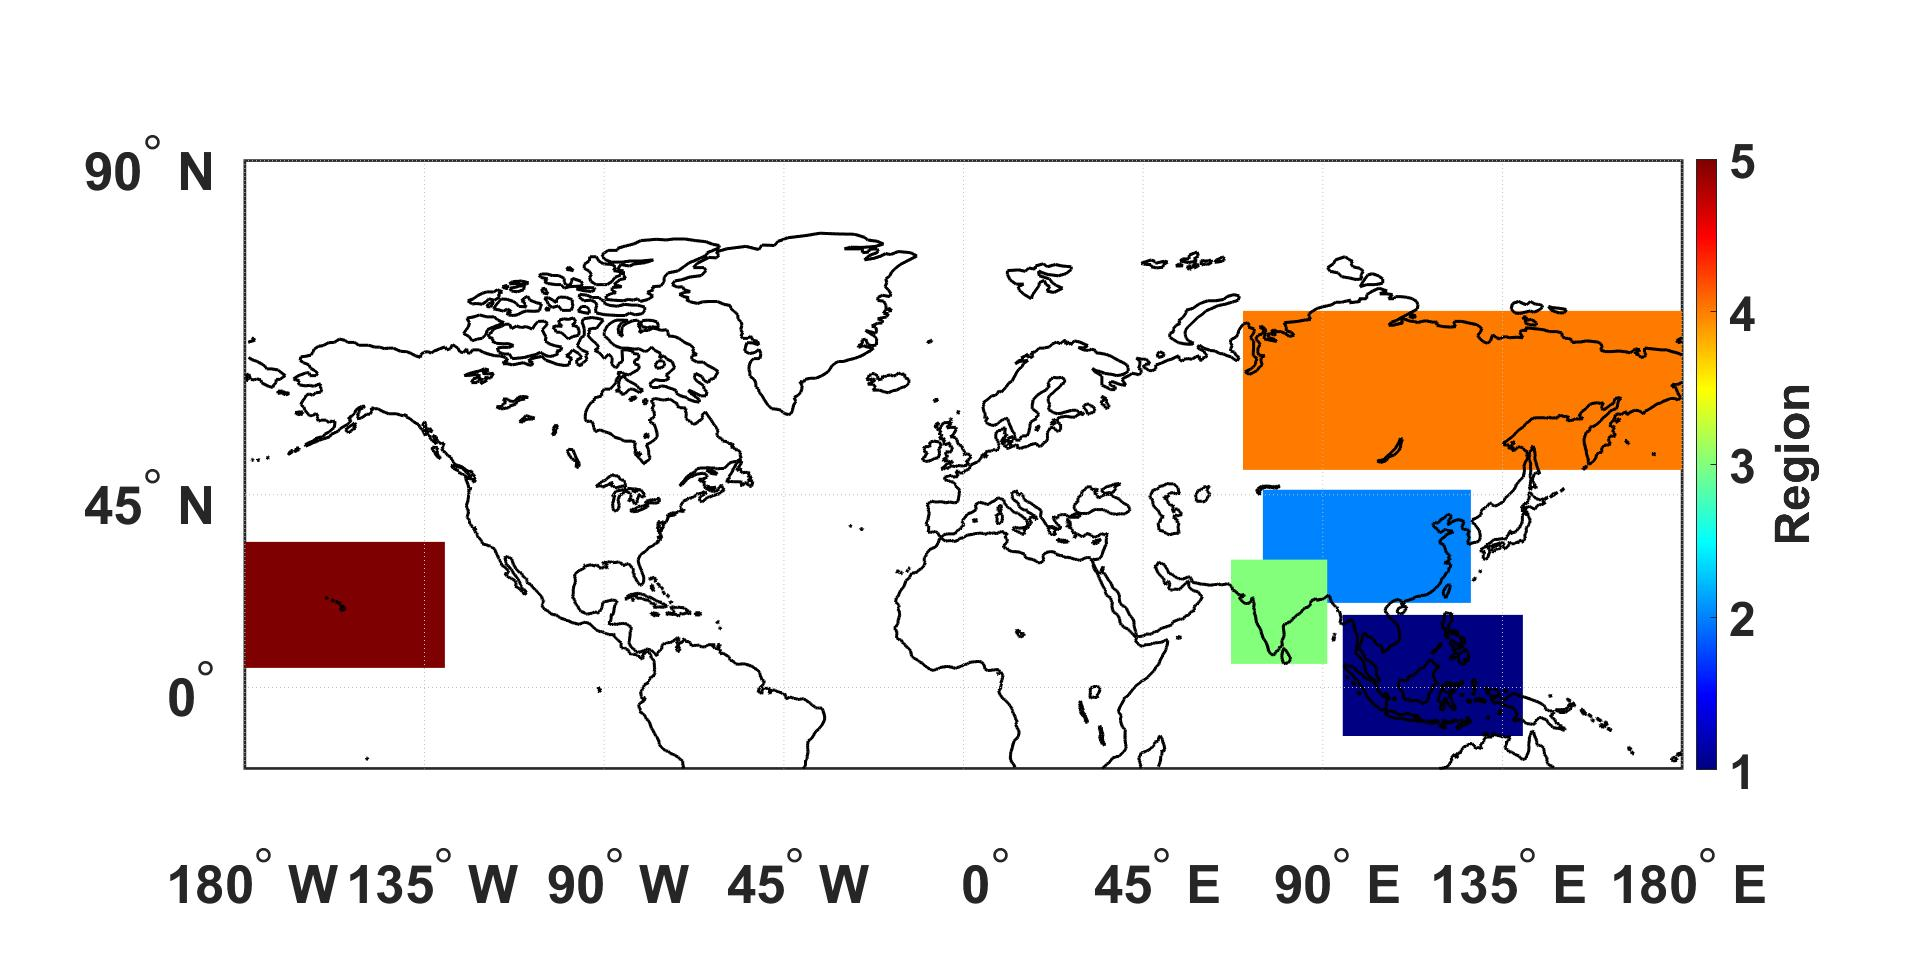

## Definition of the regions

In [83]:
rgs = {'Southeast Asia':[[-12,95],[18,140]],
       'China':[[21,75],[46,127]],
       'South Asia':[[6,67],[31,91]],
       'Siberia':[[50,70],[75,180]],
       'Tropical Pacific Ocean':[[5,-180],[35,-130]]     
      } #lower left [lat lon], upper right [lat lon]

In [87]:
rgs['China'][0]

[21, 75]

In [144]:
def multi_stats_pd(data,time,name='trop_NO2',axis=1):
    'to get a dict for the different dataframes (mean, median, min, max)'
    pds = {}
    pds['mean'] = build_pd(np.nanmean(np.nanmean(data,axis=axis),axis=axis),time,name='mean_'+name)
    pds['median'] = build_pd(np.nanmedian(np.nanmedian(data,axis=axis),axis=axis),time,name='median_'+name)
    pds['min'] = build_pd(np.nanmin(np.nanmin(data,axis=axis),axis=axis),time,name='min_'+name)
    pds['max'] = build_pd(np.nanmax(np.nanmax(data,axis=axis),axis=axis),time,name='max_'+name)
    pds['std'] = build_pd(np.nanstd(np.nanstd(data,axis=axis),axis=axis),time,name='std_'+name)
    
    return pds
    

In [88]:
def build_pd(data,time,name='mean_trop_NO2'):
    'To prepare the dataframe with time settings and regular interpolation, ready for seasonal decomposition'
    data_pd = pd.DataFrame(data=data)
    data_pd['time'] = pd.to_datetime(time)
    data_pd[name] = data
    data_pd.set_index('time', inplace = True)
    data_pd.dropna(inplace=True)
    dat = data_pd.resample('M').mean()
    dat.interpolate(inplace=True)
    return dat

## Subset for GOME NO2

In [145]:
gome_rg = {}
for rg in rgs: 
    print(rg)
    ill_lon = np.argmin(np.abs(gome[b'lon']-rgs[rg][0][1]))
    ill_lat = np.argmin(np.abs(gome[b'lat']-rgs[rg][0][0]))
    iur_lon = np.argmin(np.abs(gome[b'lon']-rgs[rg][1][1]))
    iur_lat = np.argmin(np.abs(gome[b'lat']-rgs[rg][1][0]))
    
    gome_rg[rg] = multi_stats_pd(gome[b'TroposNO2'][:,ill_lat:iur_lat,ill_lon:iur_lon],gometime,name='GOME_tropNO2')
    

Southeast Asia


/home/sam/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


China


/home/sam/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


South Asia


/home/sam/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Siberia


/home/sam/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Tropical Pacific Ocean


/home/sam/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [148]:
gome_rg['China'].keys()

dict_keys(['mean', 'median', 'min', 'max', 'std'])

In [151]:
gome_rg['China']['mean']['mean_GOME_tropNO2']

time
1996-04-30    1.859328
1996-05-31    1.301909
1996-06-30    1.278765
1996-07-31    1.105478
1996-08-31    0.905335
                ...   
2017-05-31    2.441311
2017-06-30    2.812031
2017-07-31    2.251210
2017-08-31    2.162282
2017-09-30    2.287339
Freq: M, Name: mean_GOME_tropNO2, Length: 258, dtype: float32

# Plot out data

## GOME Tropospheric NO2 one location

<IPython.core.display.Javascript object>


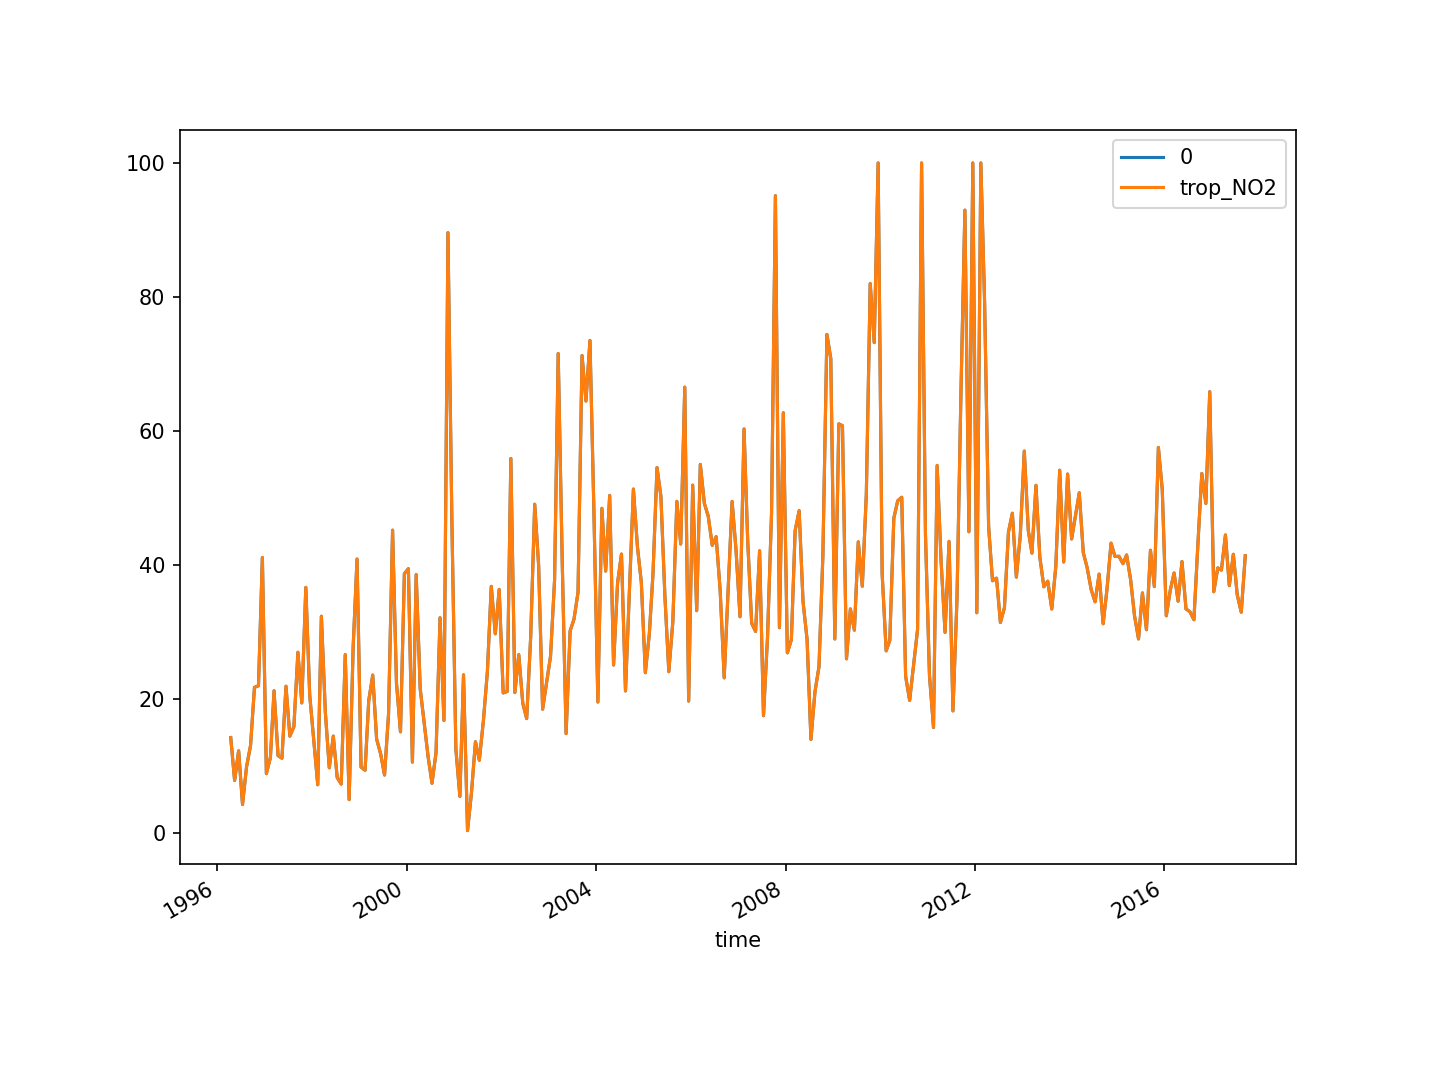

<AxesSubplot:xlabel='time'>

In [49]:
gome_NO2_pd.plot()

Run the stats models

<IPython.core.display.Javascript object>


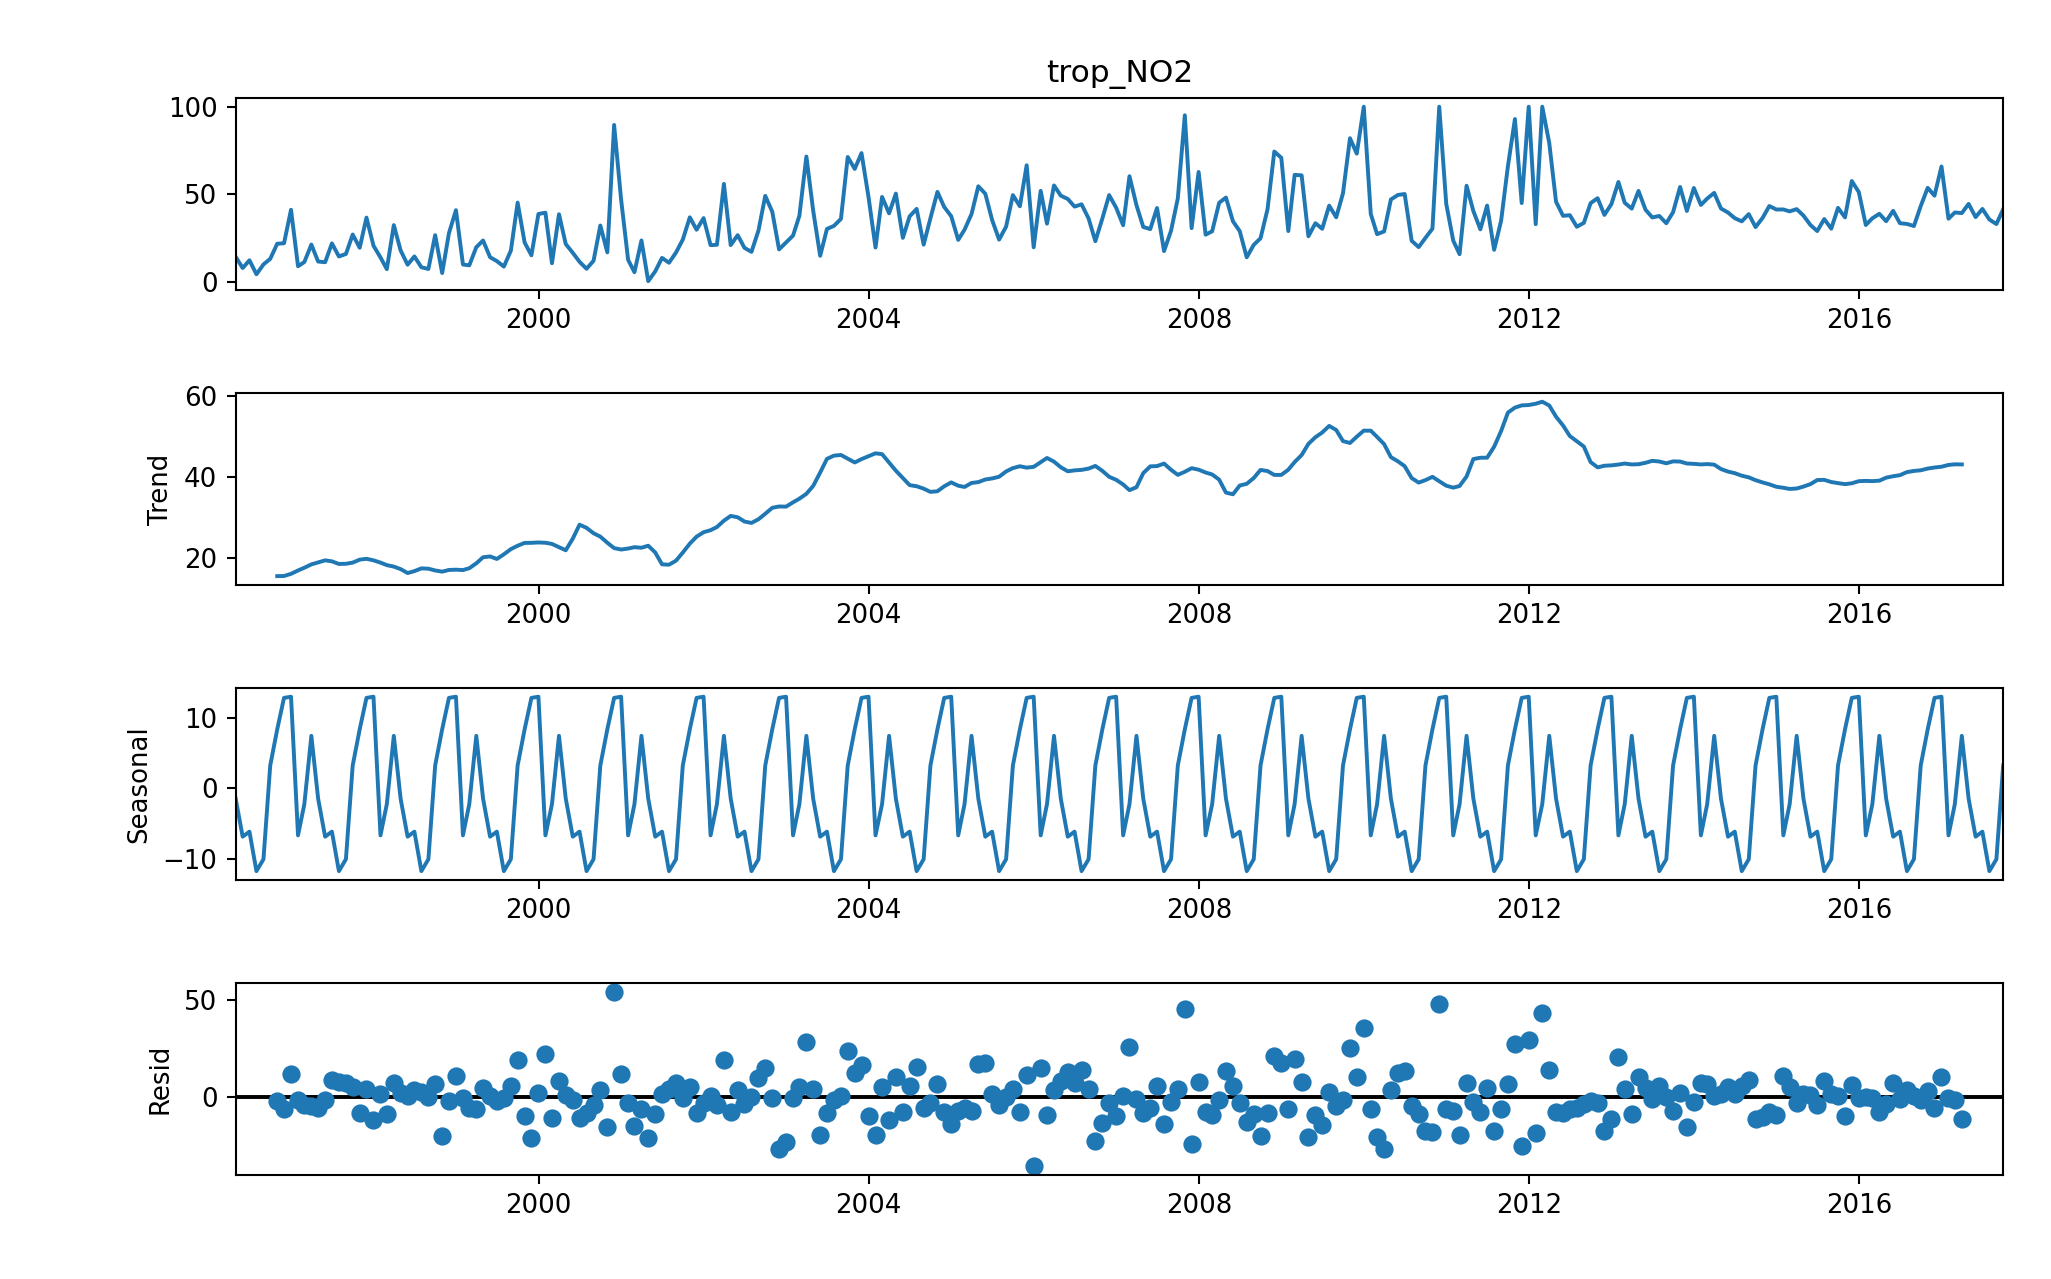

In [58]:
result_gome = seasonal_decompose(gno2['trop_NO2'])
p = result_gome.plot()

<IPython.core.display.Javascript object>


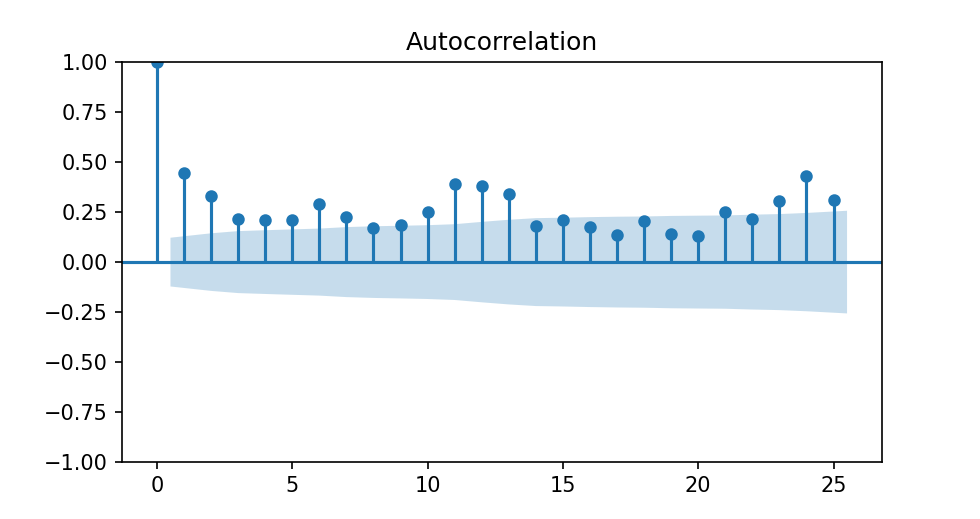

In [57]:
fig, ax = plt.subplots(figsize = (4,2))
plot_acf(gno2['trop_NO2'], ax = ax)
plt.show()

## GOME NO2 regions

<IPython.core.display.Javascript object>


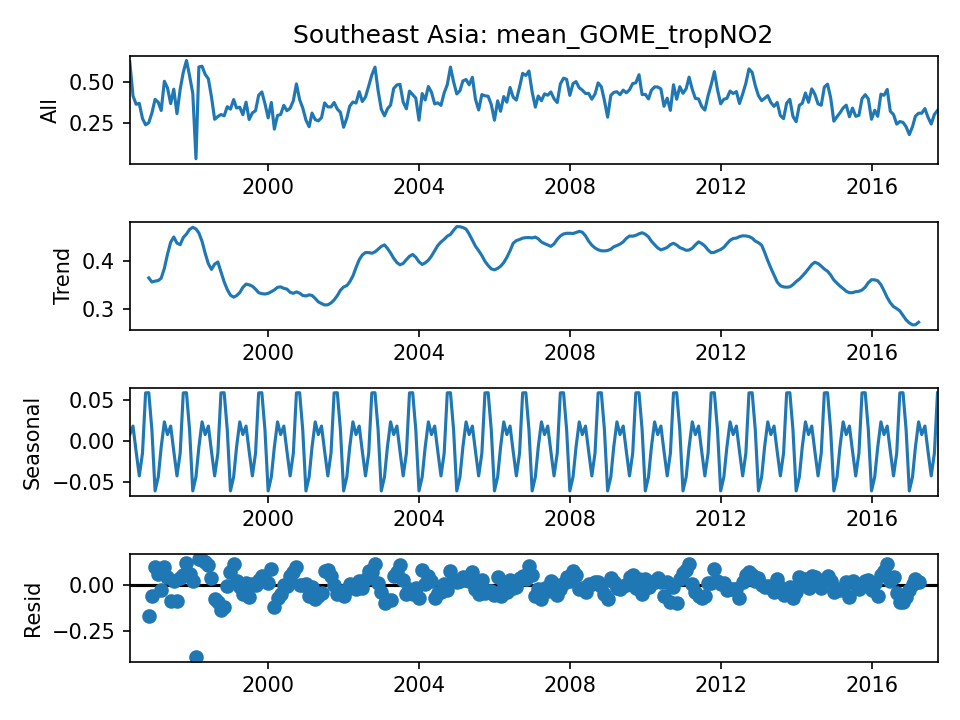

<IPython.core.display.Javascript object>


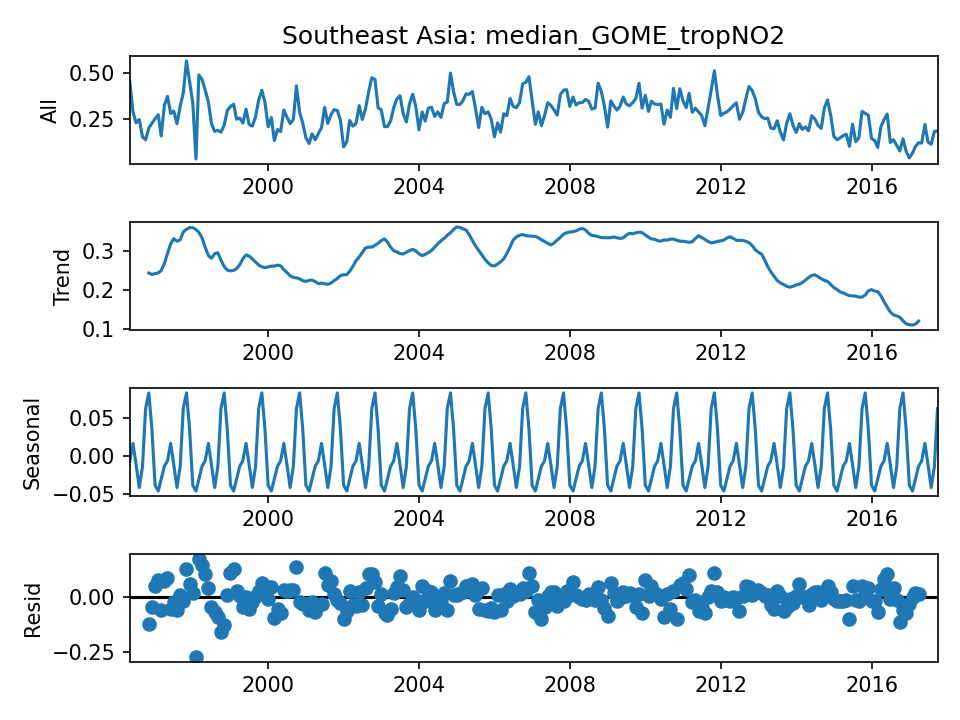

<IPython.core.display.Javascript object>


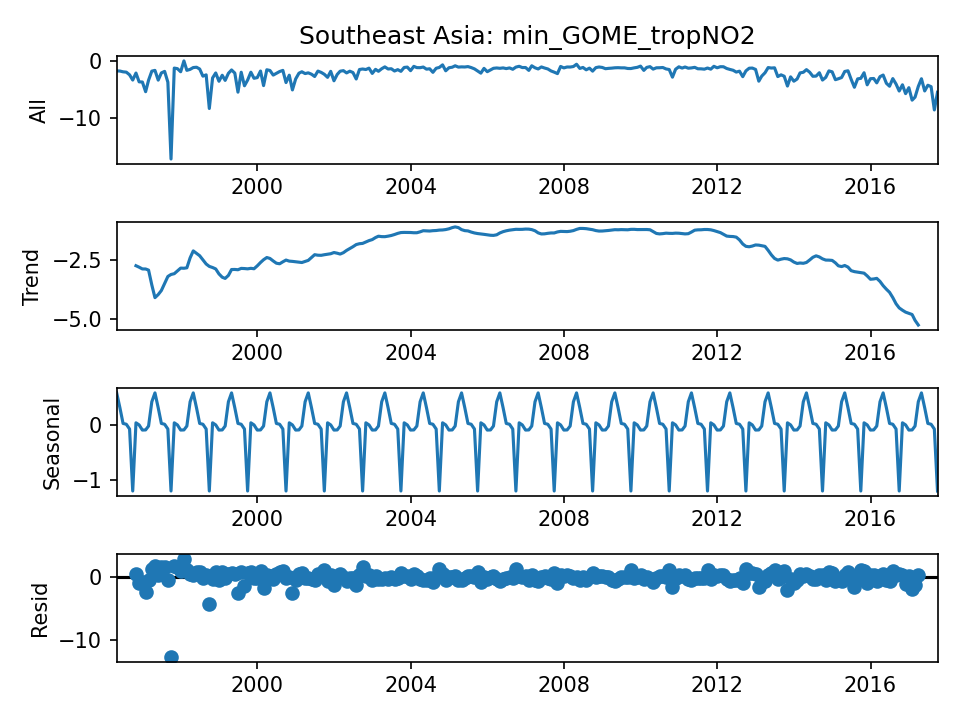

<IPython.core.display.Javascript object>


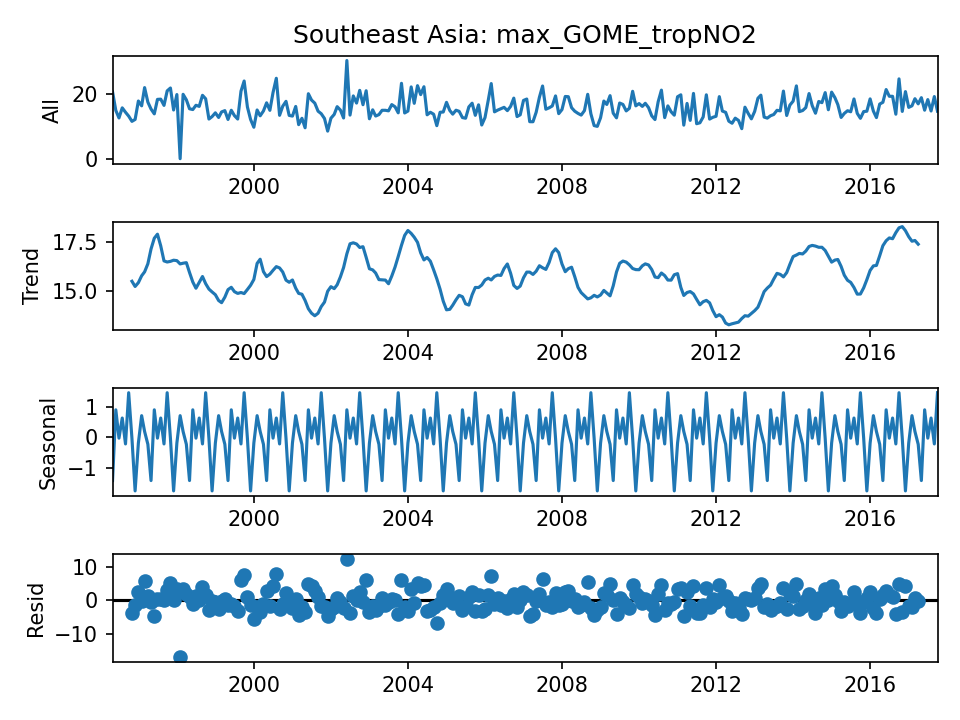

<IPython.core.display.Javascript object>


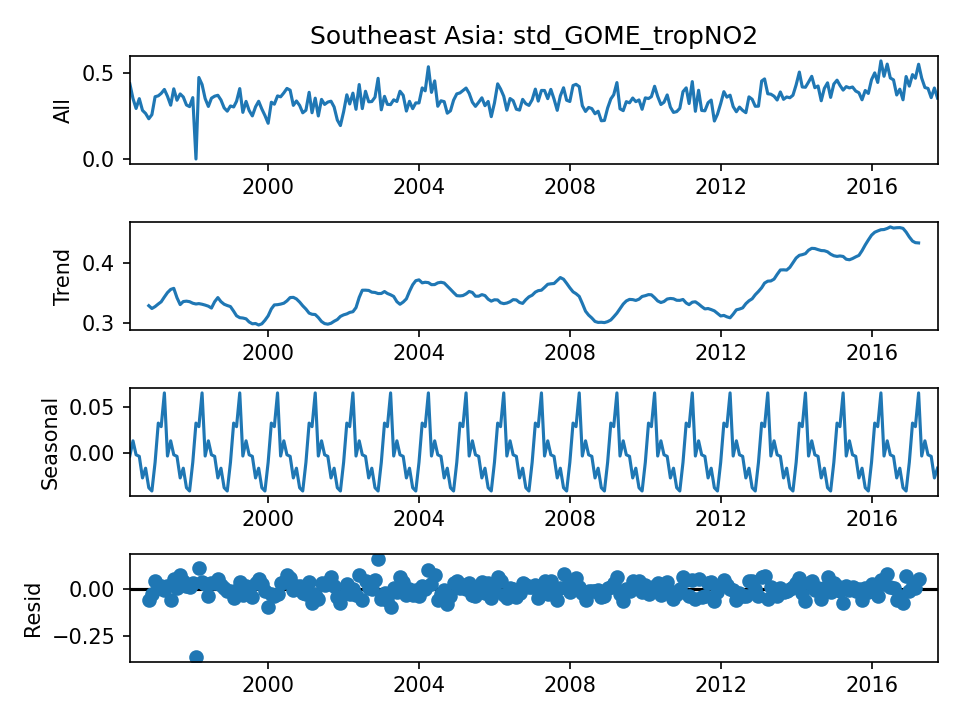

<IPython.core.display.Javascript object>


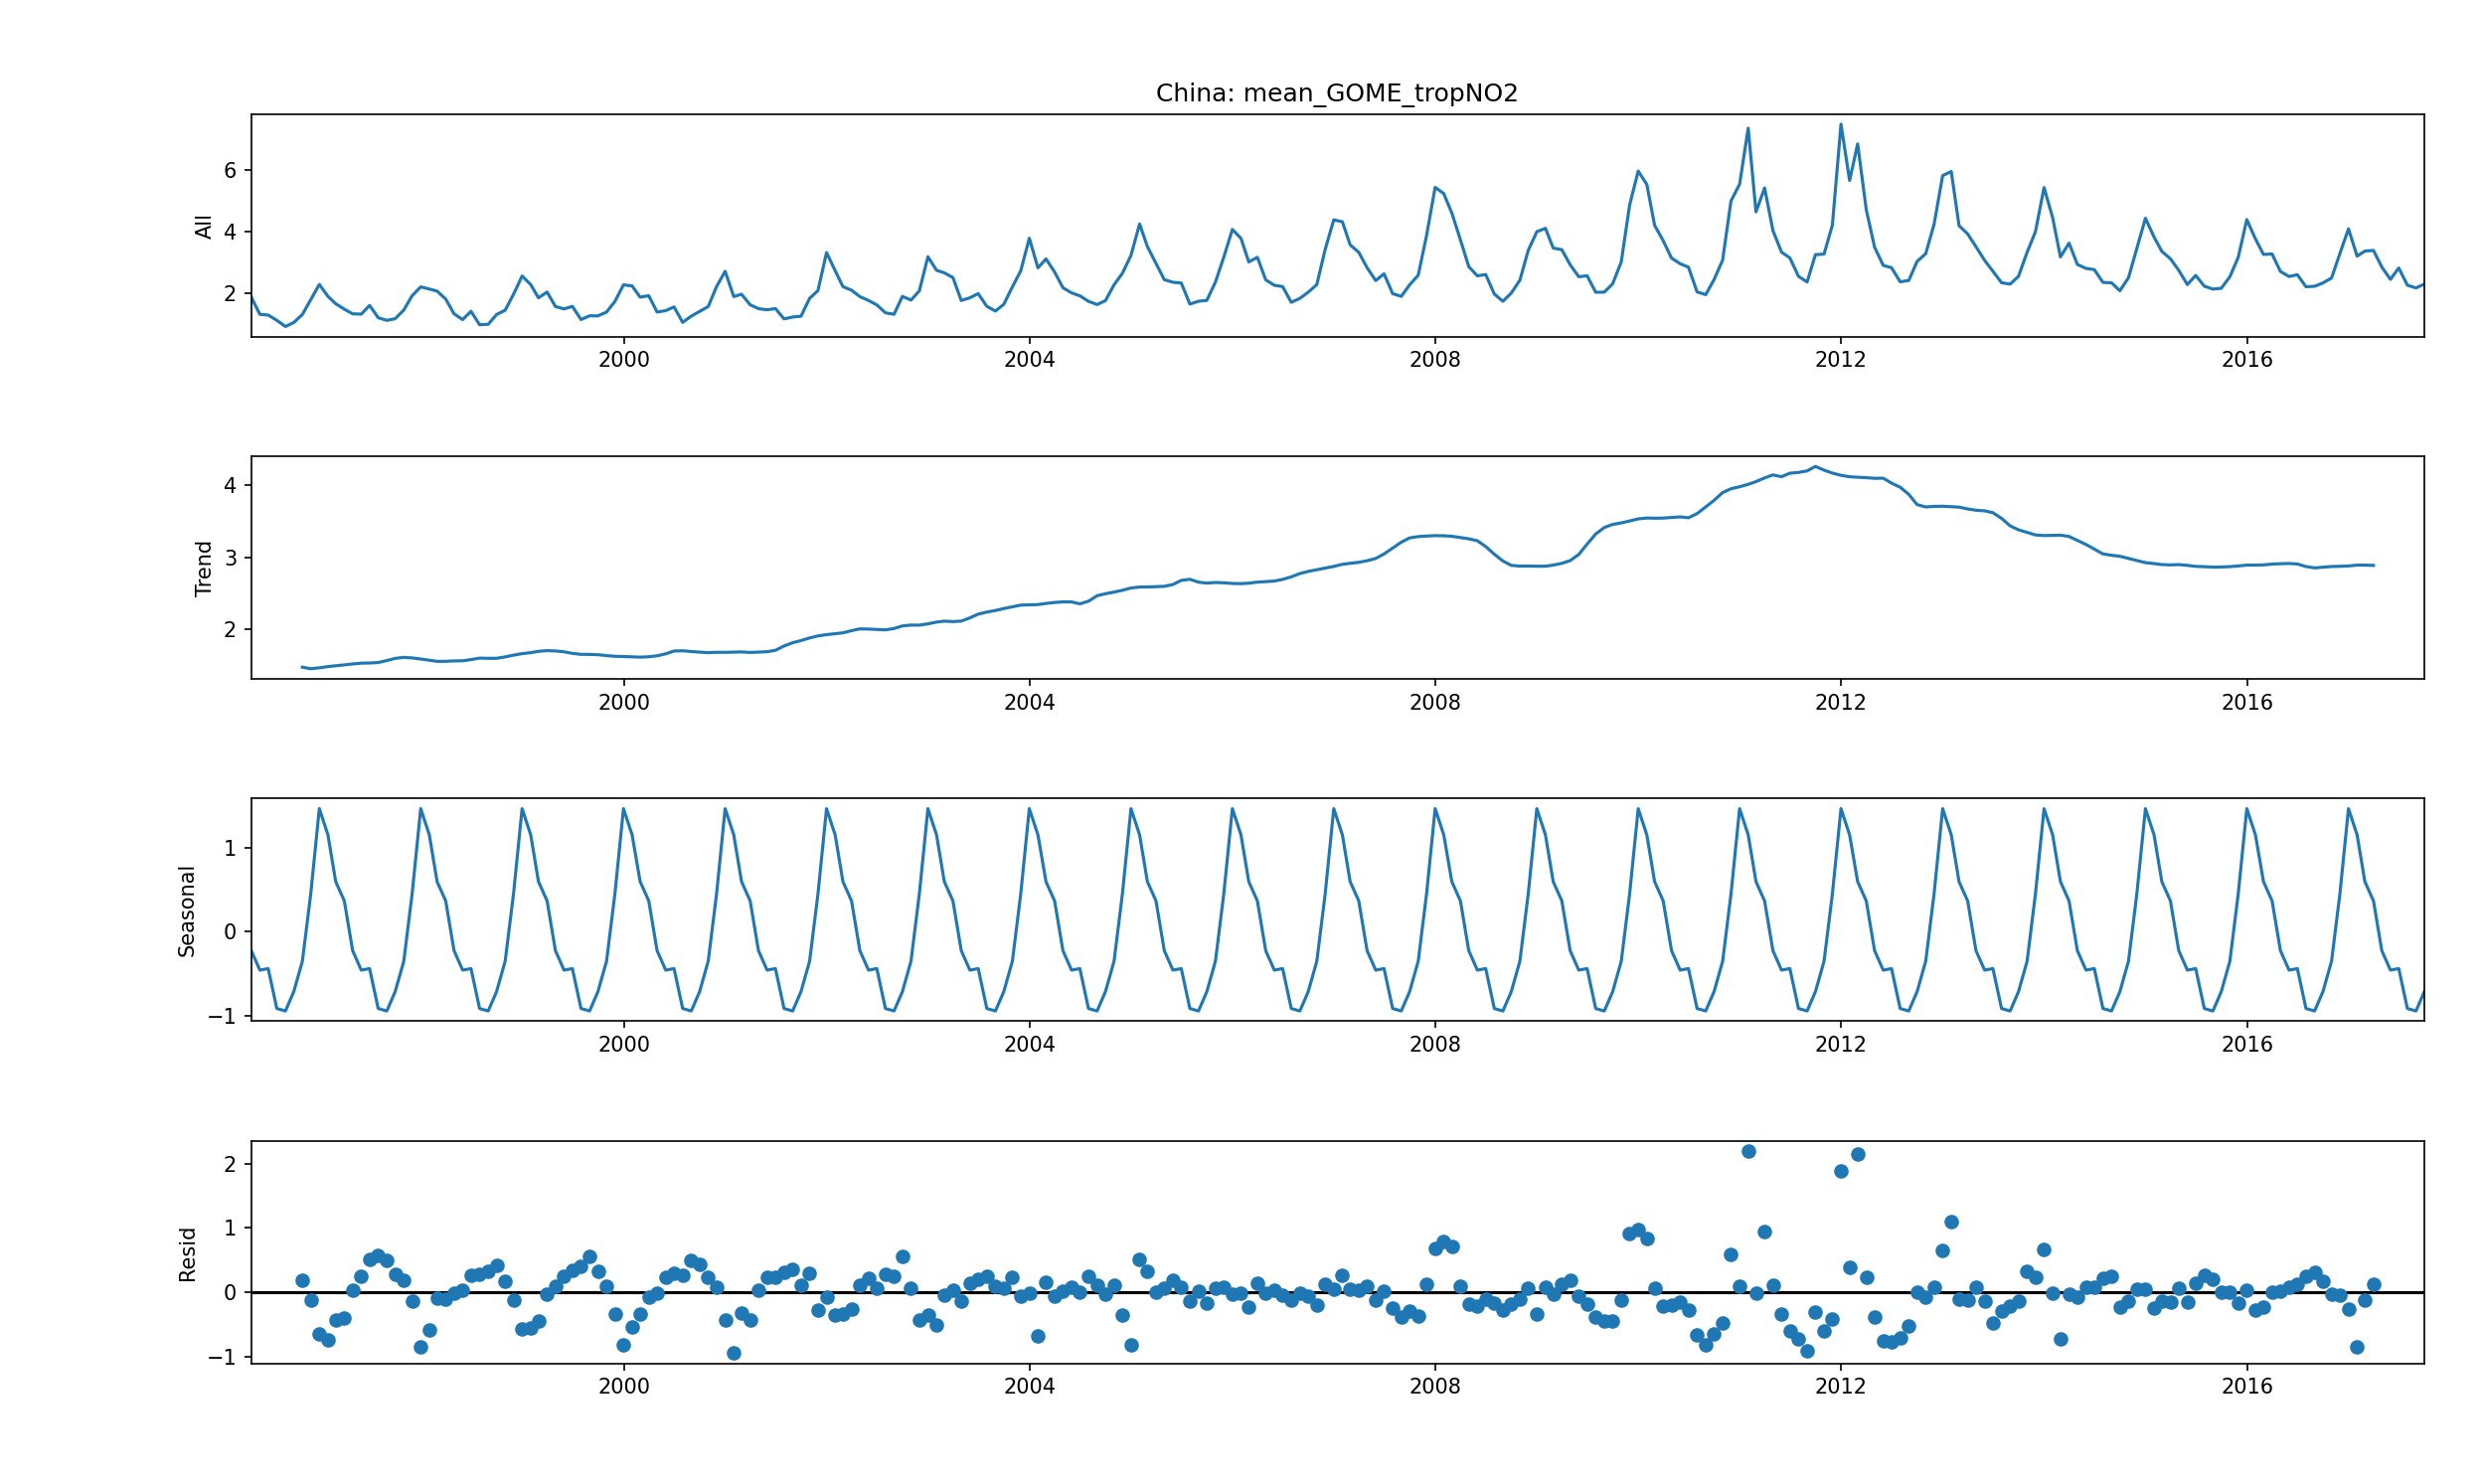

<IPython.core.display.Javascript object>


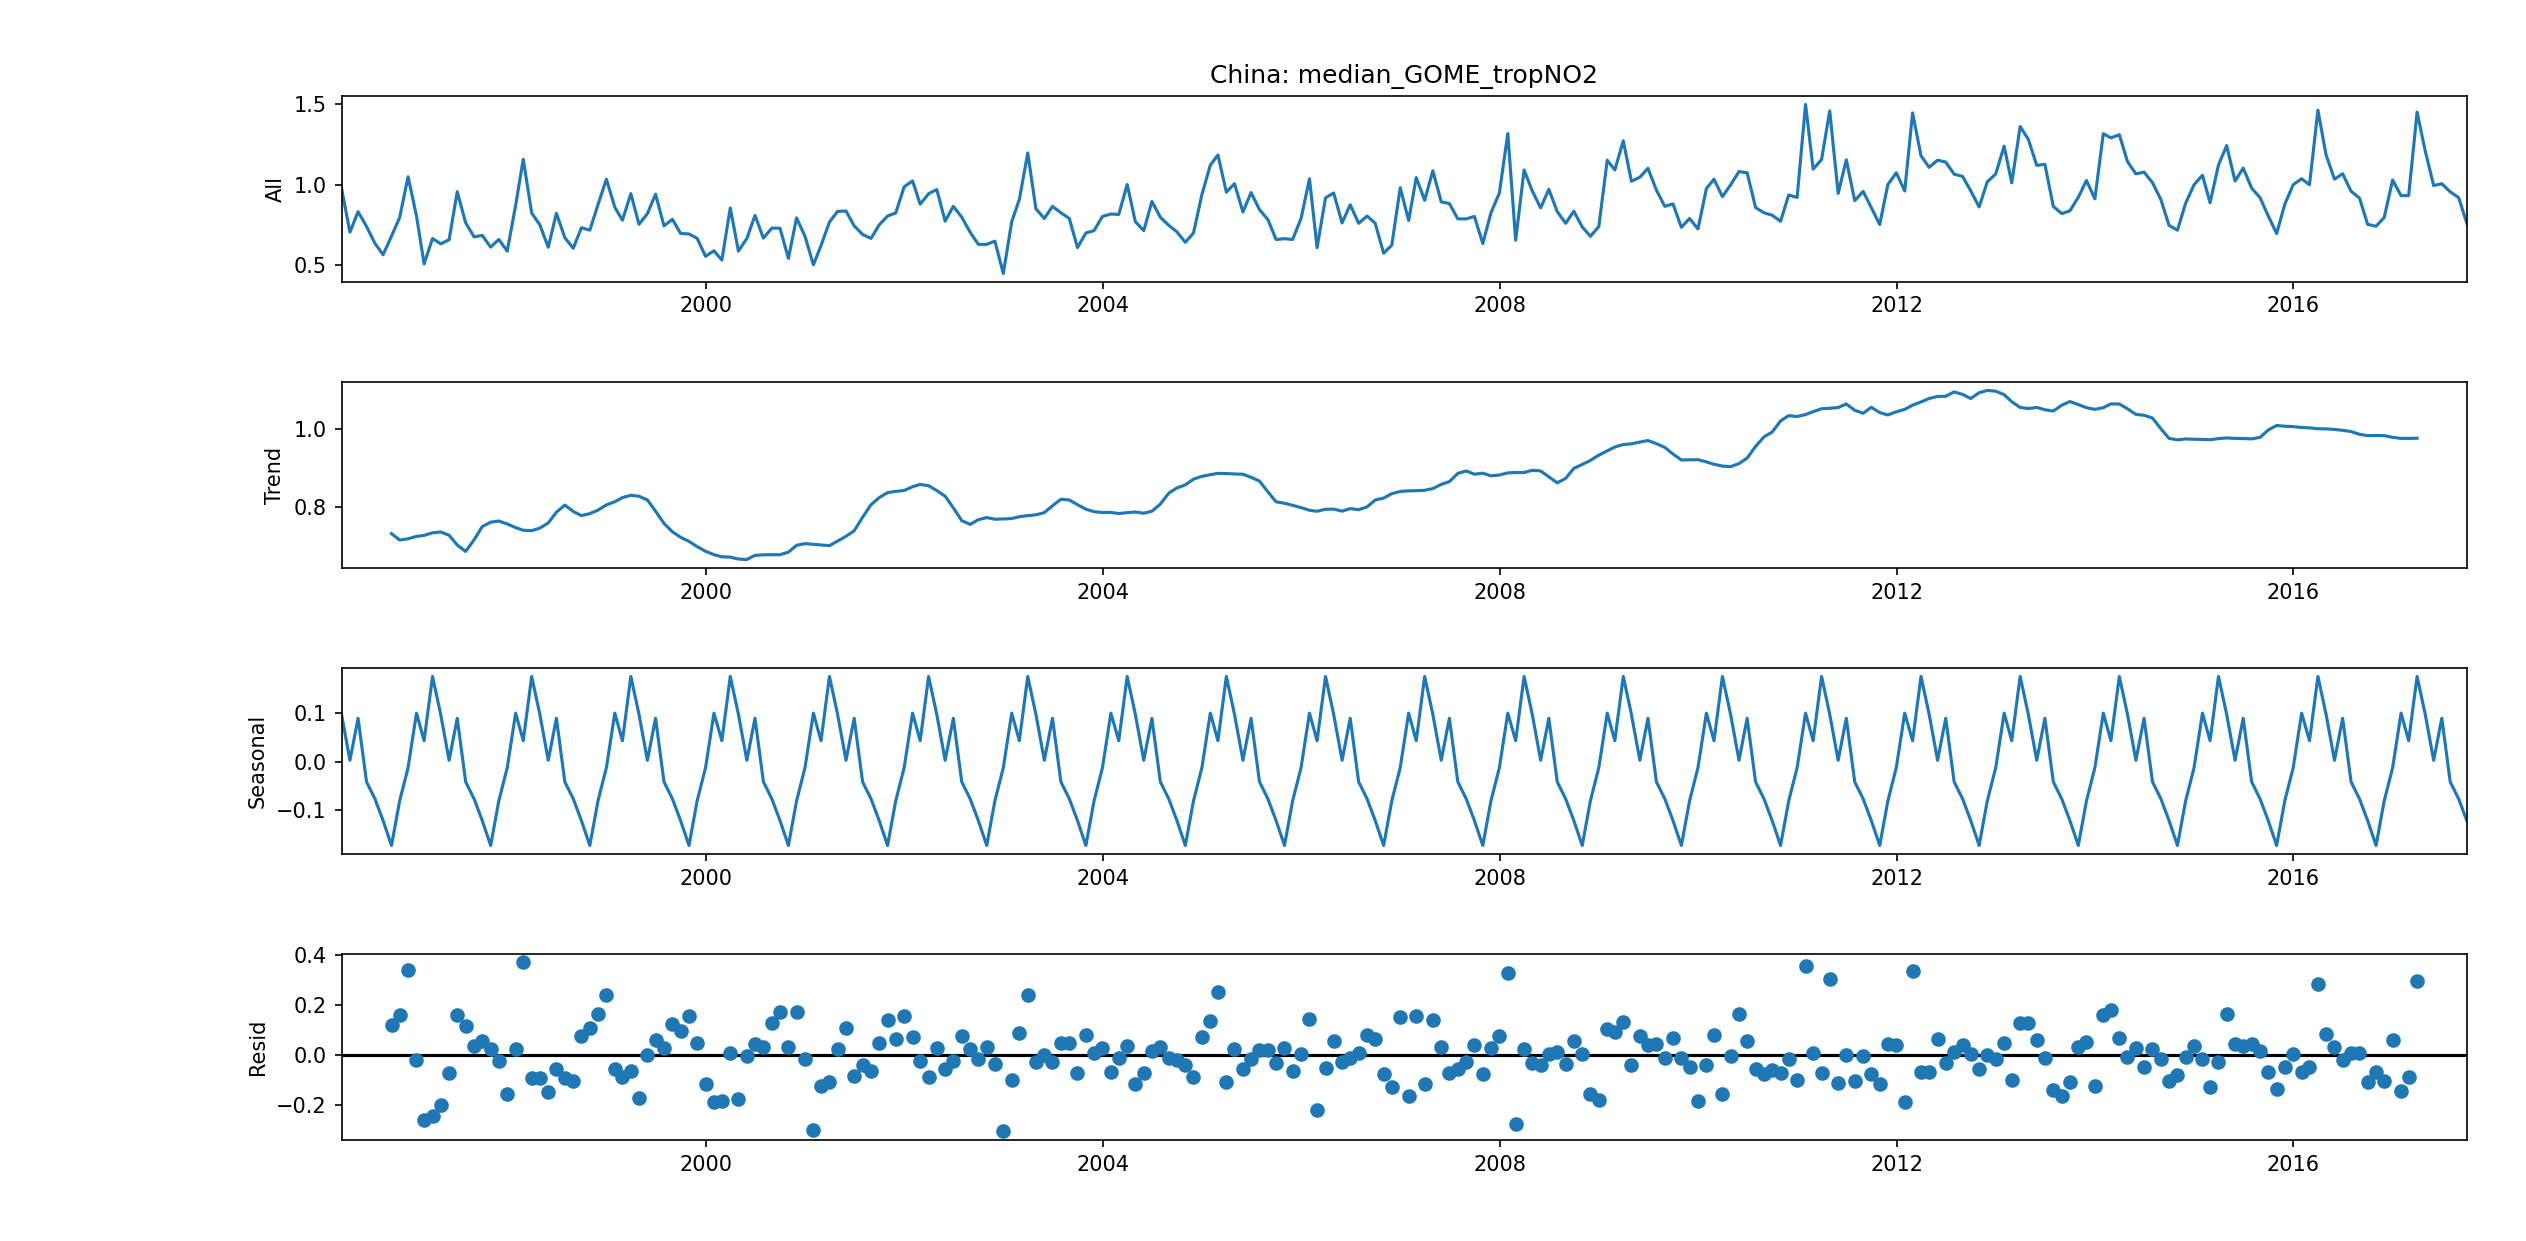

<IPython.core.display.Javascript object>


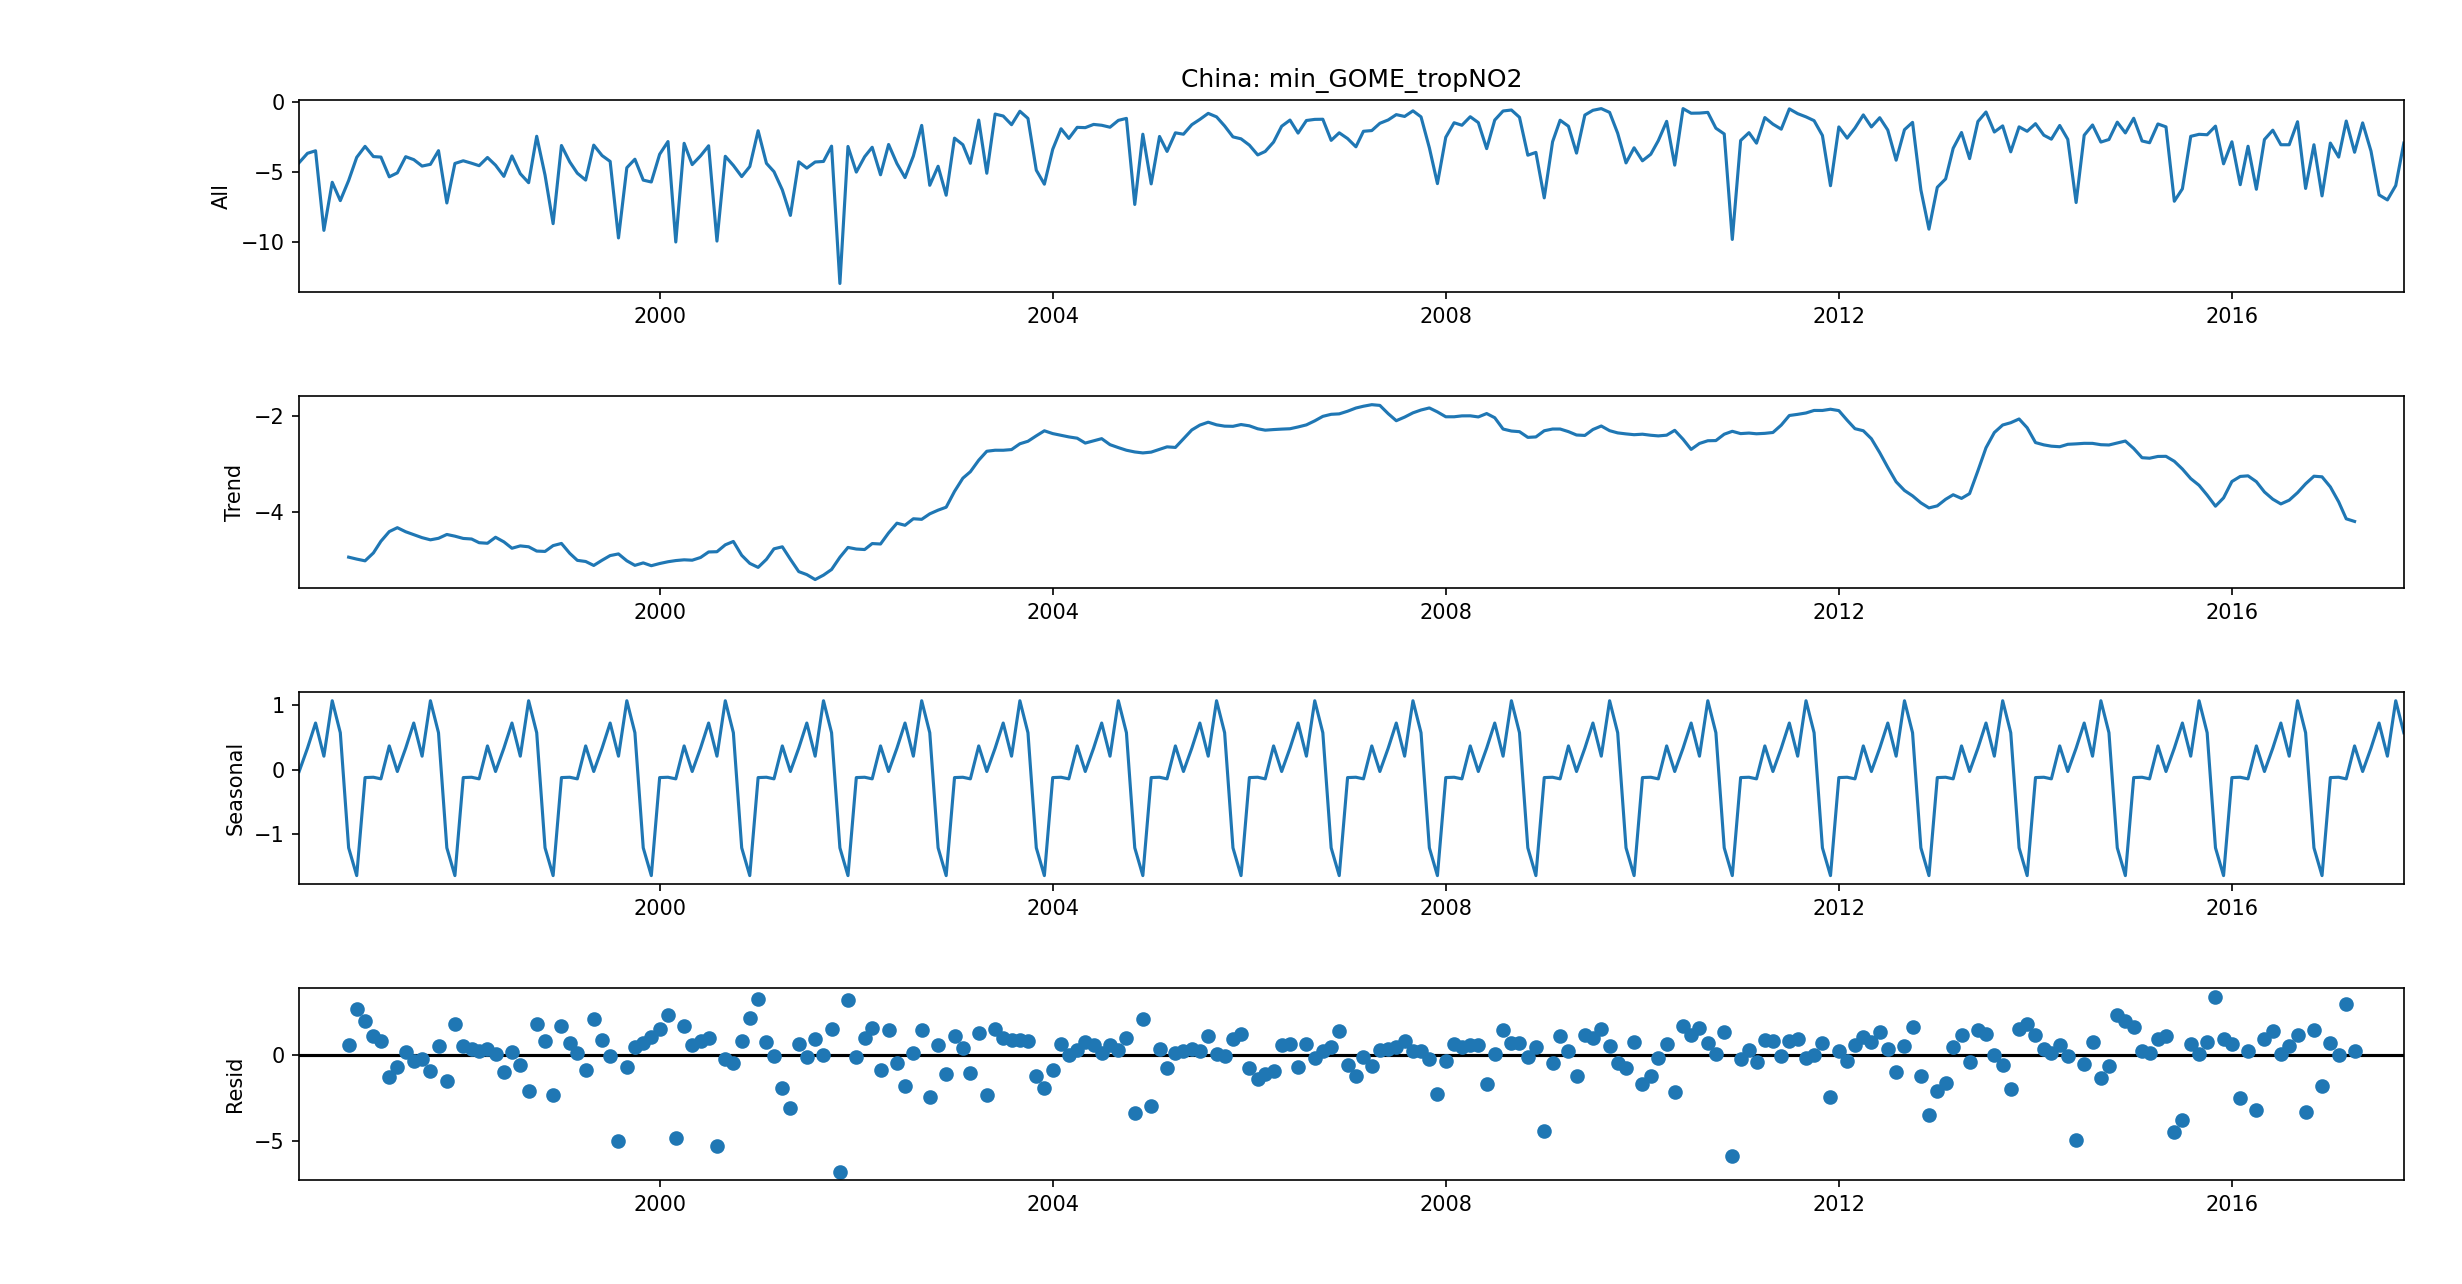

<IPython.core.display.Javascript object>


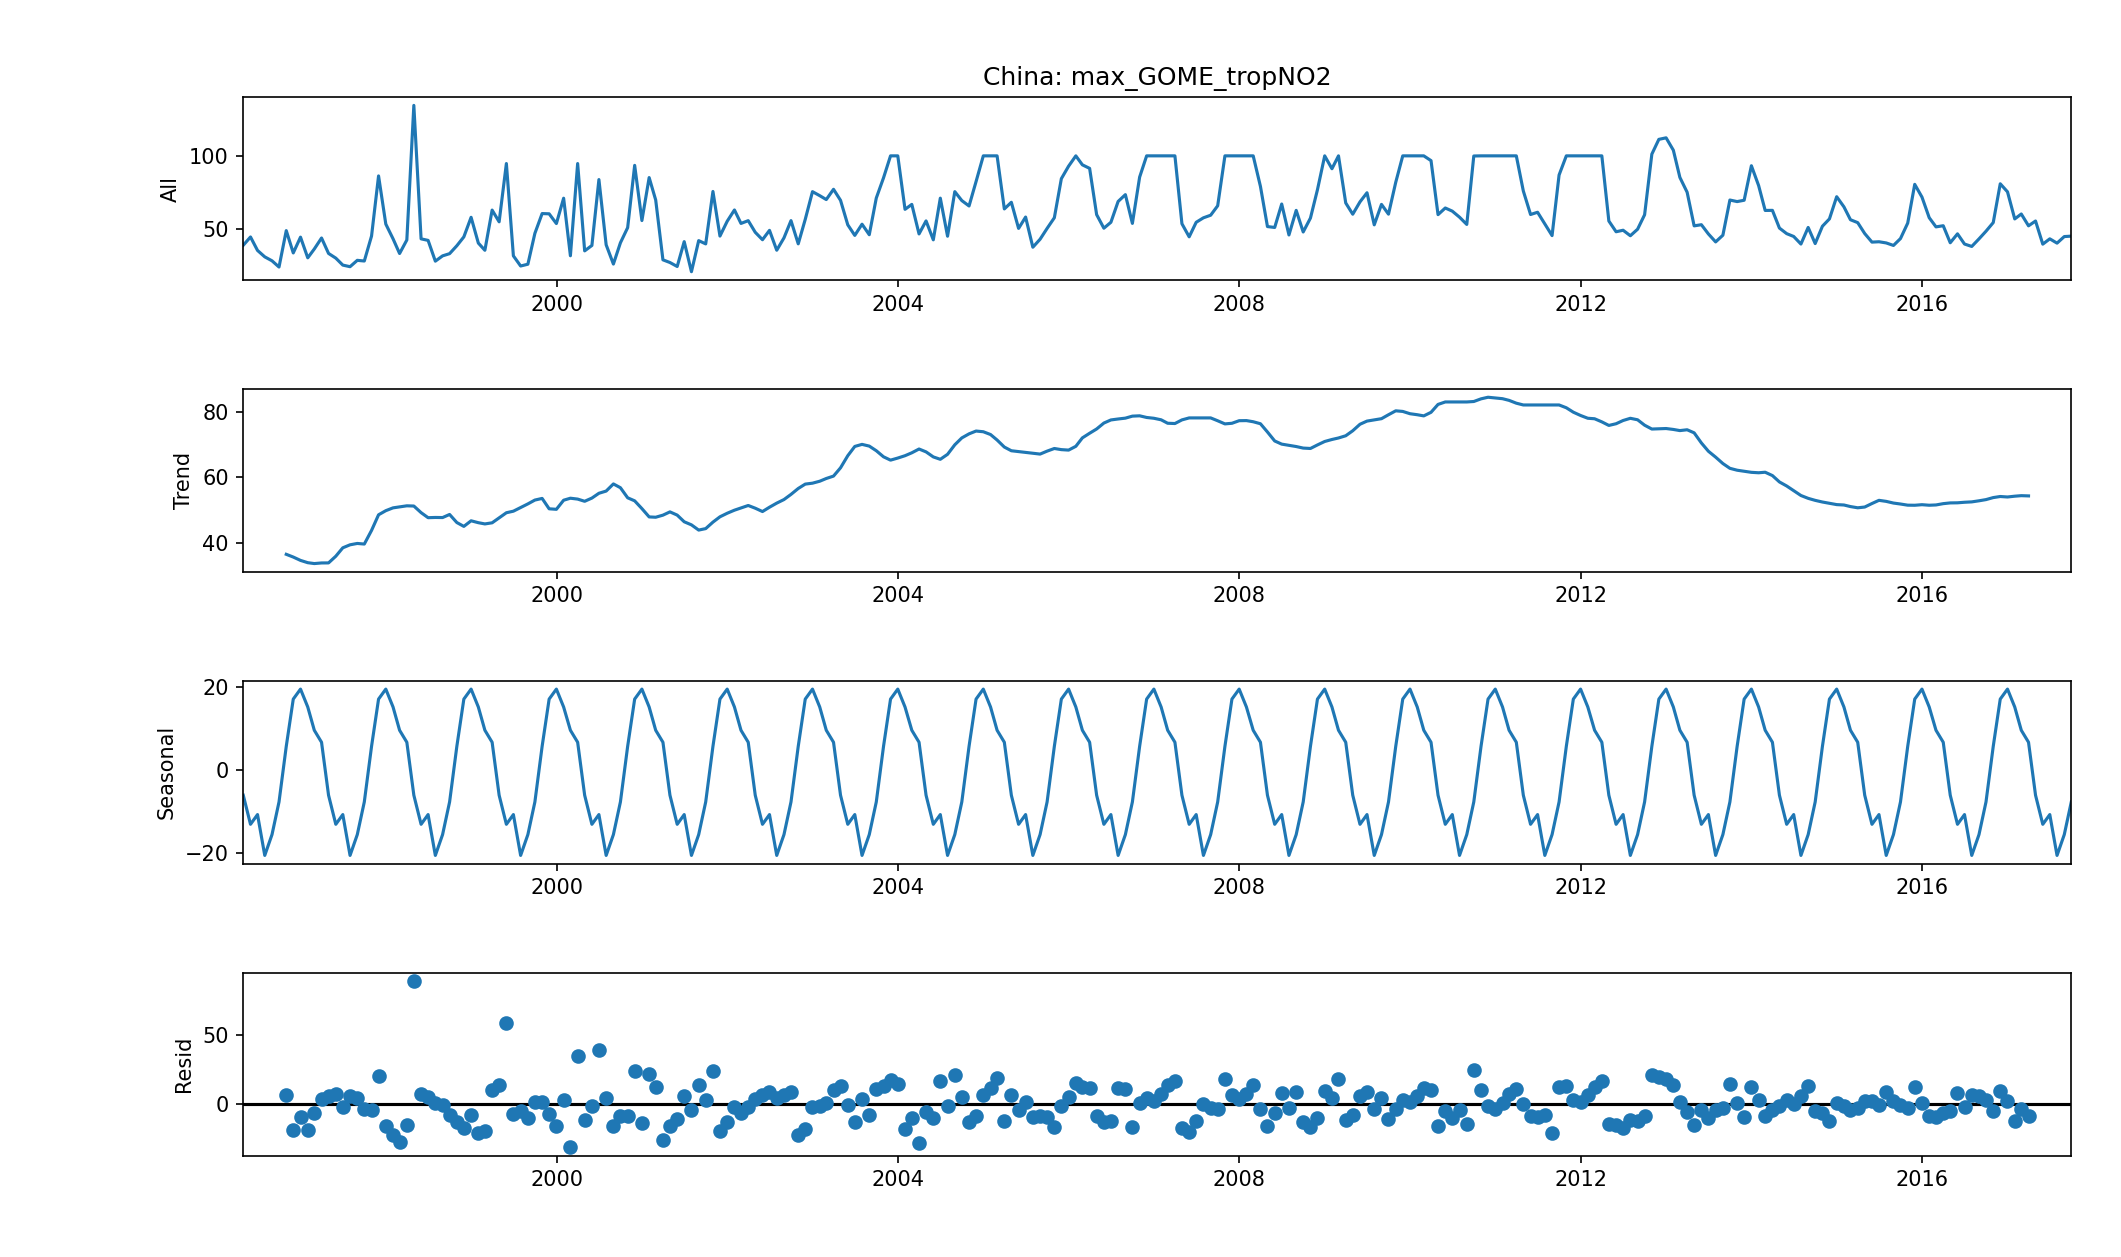

<IPython.core.display.Javascript object>


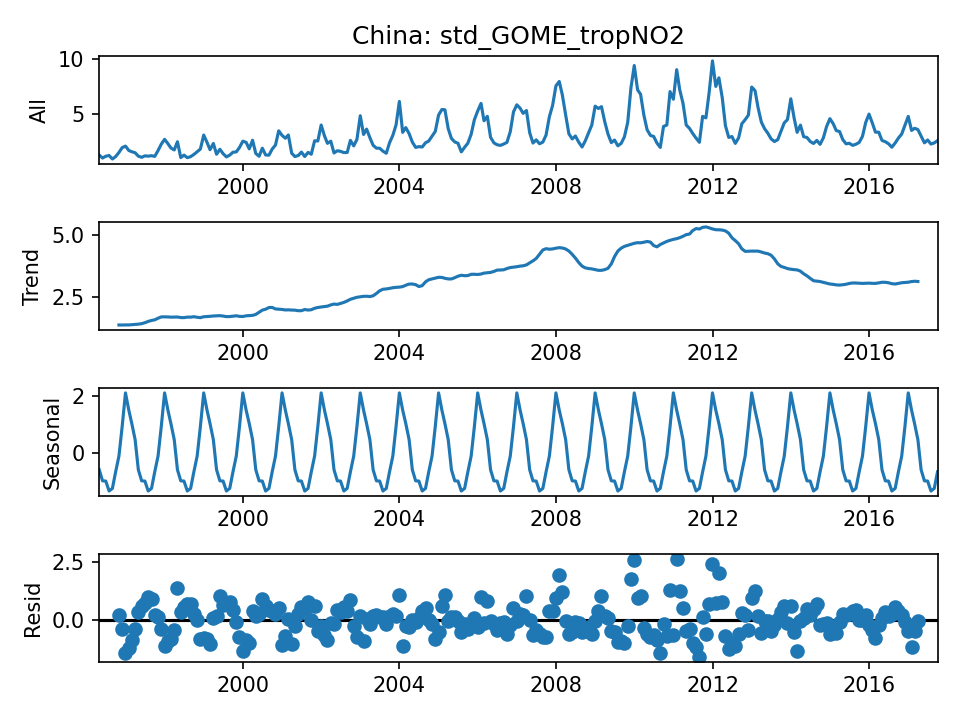

<IPython.core.display.Javascript object>


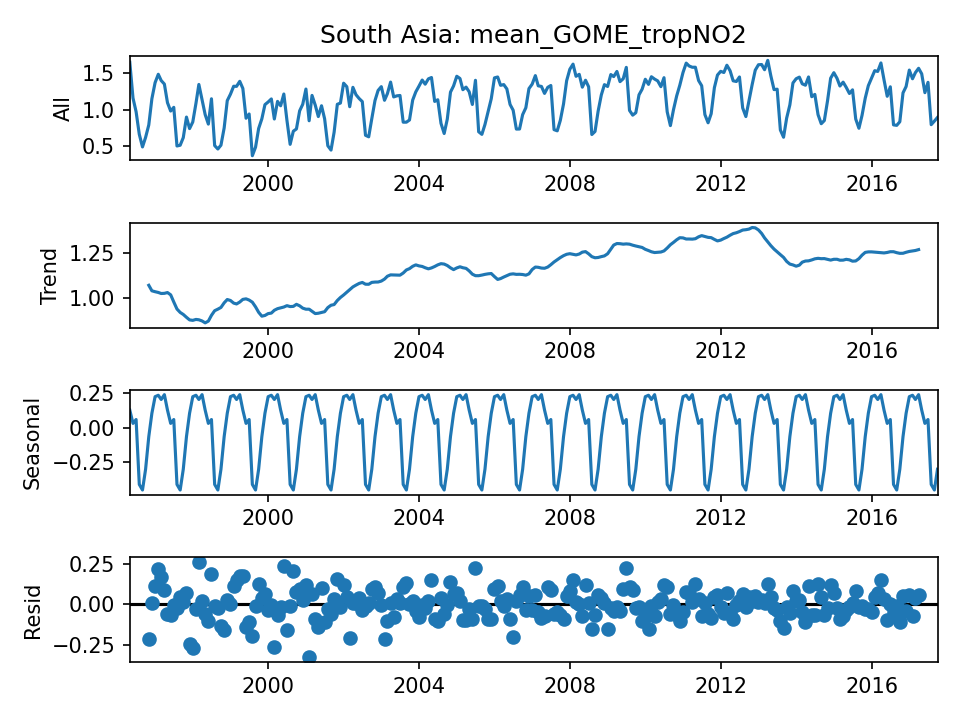

<IPython.core.display.Javascript object>


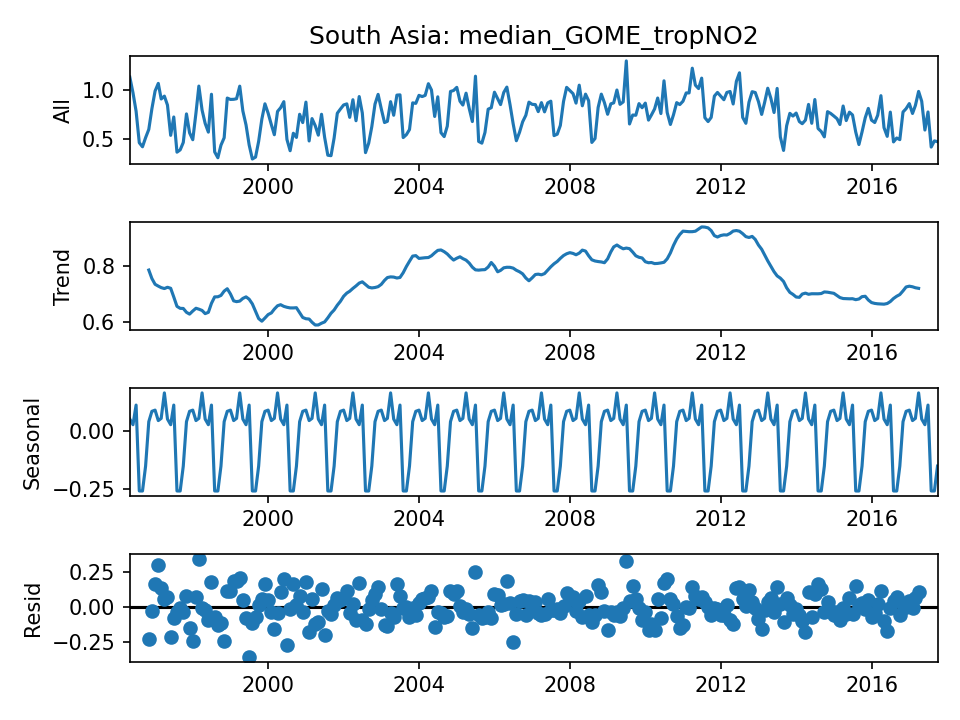

<IPython.core.display.Javascript object>


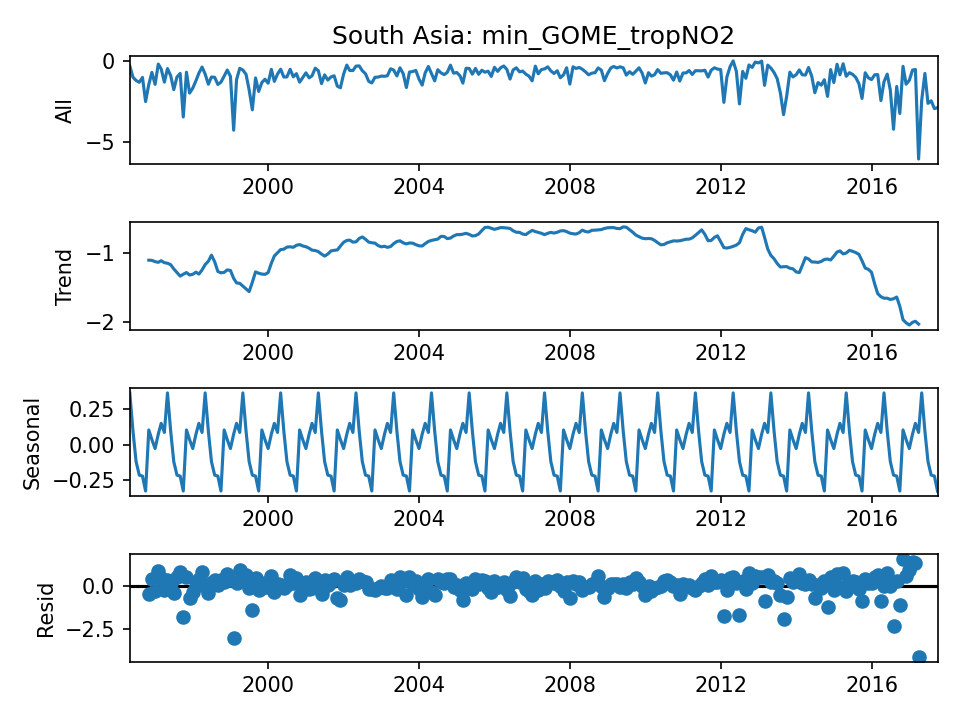

<IPython.core.display.Javascript object>


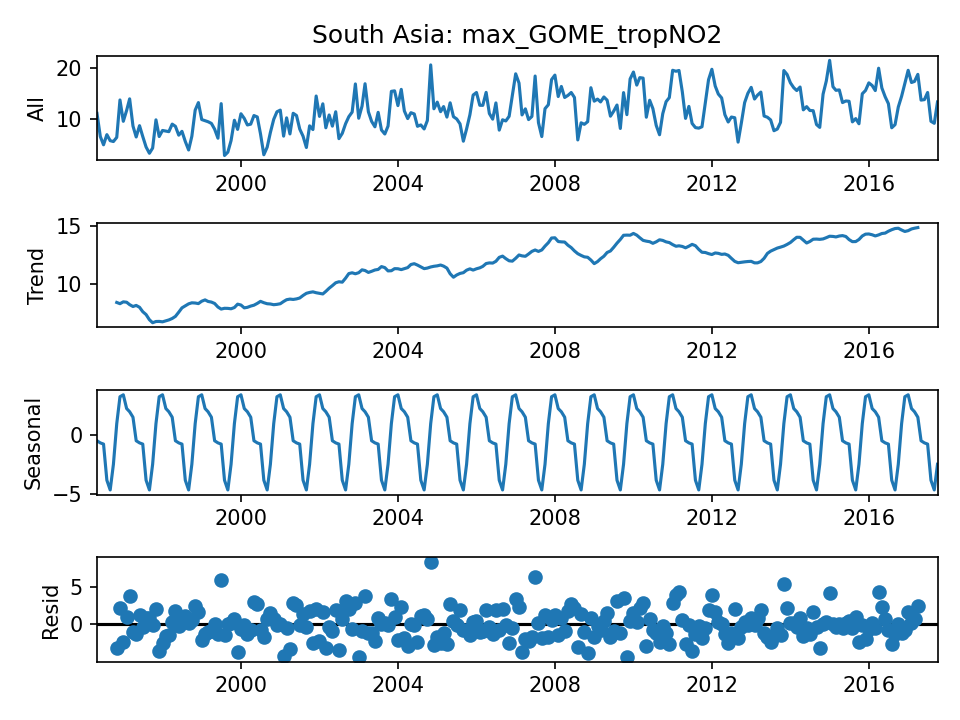

<IPython.core.display.Javascript object>


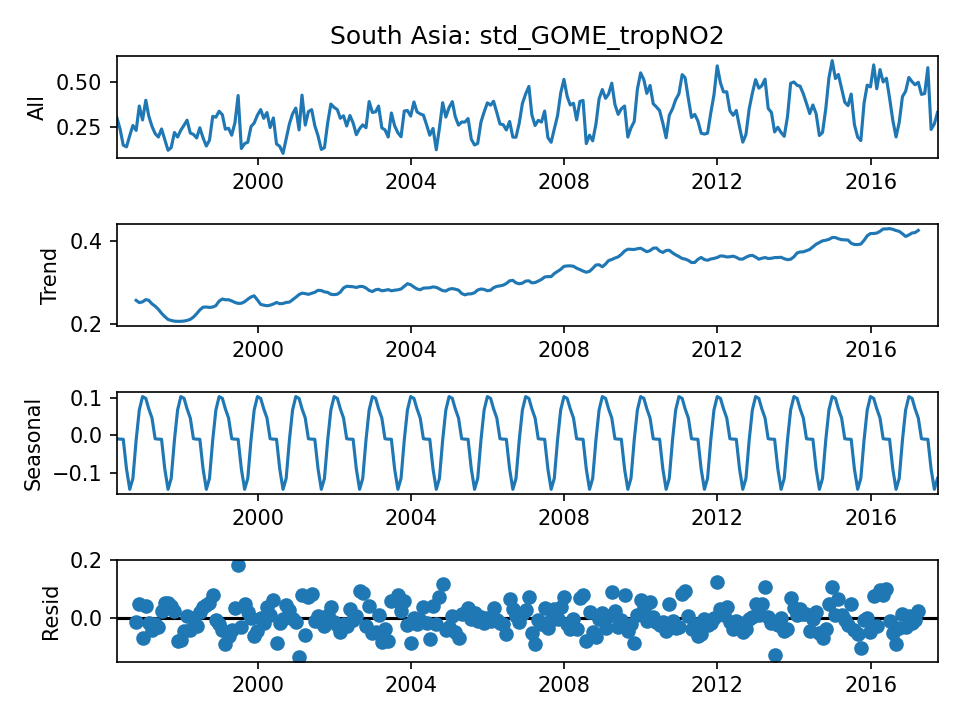

<IPython.core.display.Javascript object>


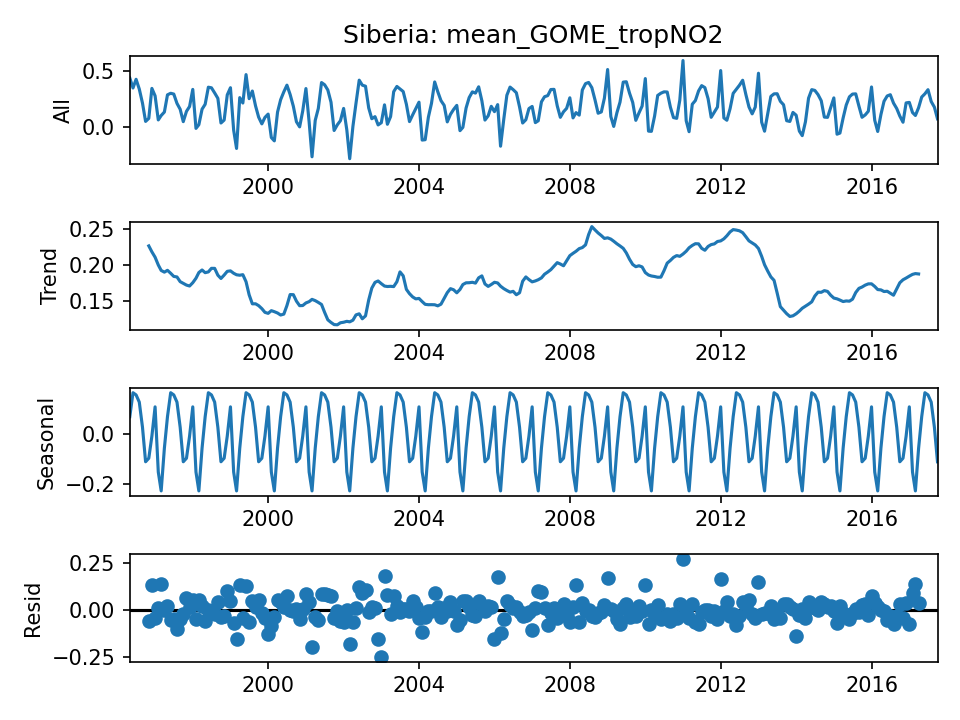

<IPython.core.display.Javascript object>


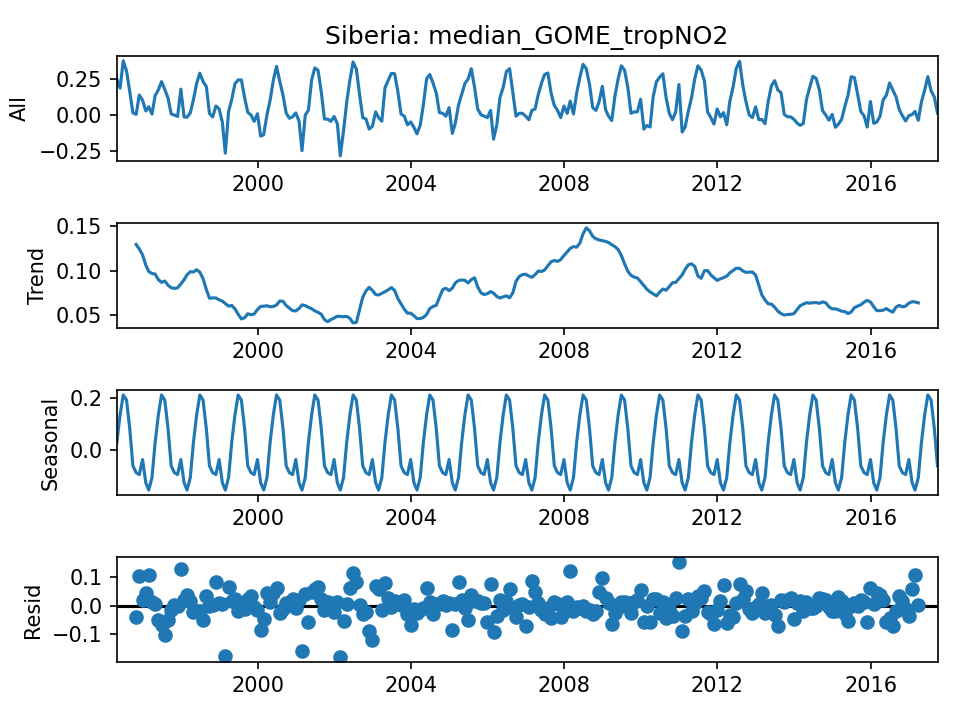

<IPython.core.display.Javascript object>


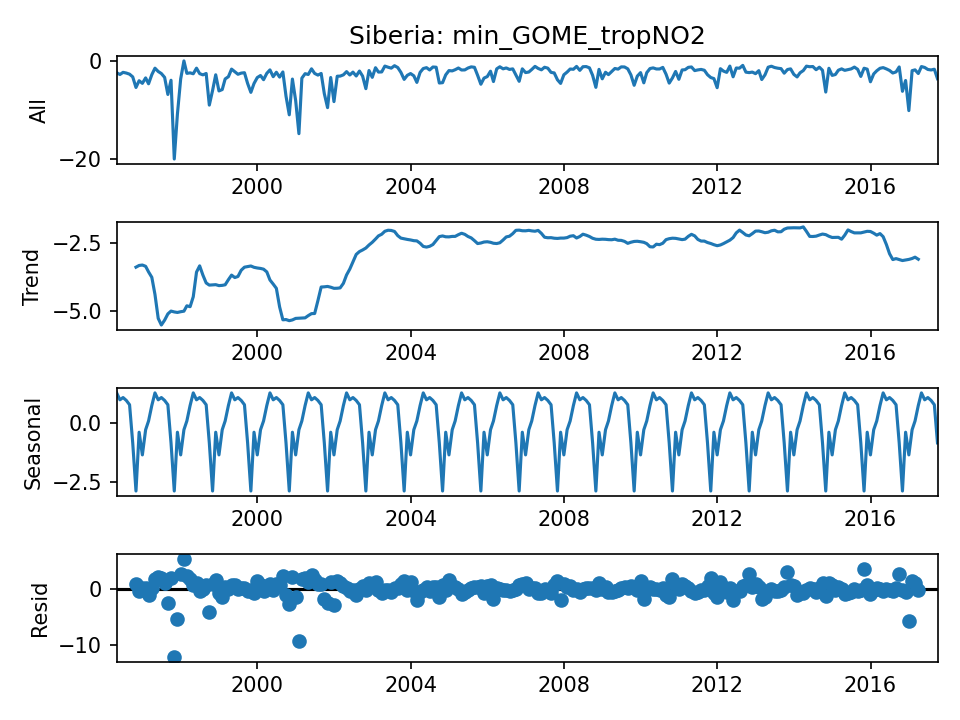

<IPython.core.display.Javascript object>


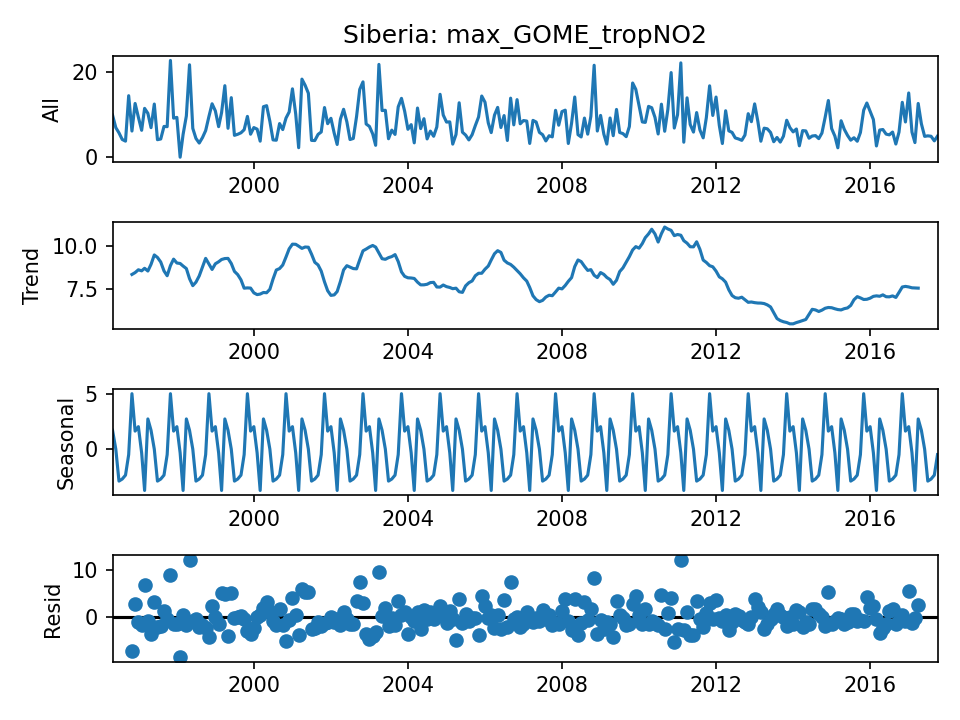

<IPython.core.display.Javascript object>


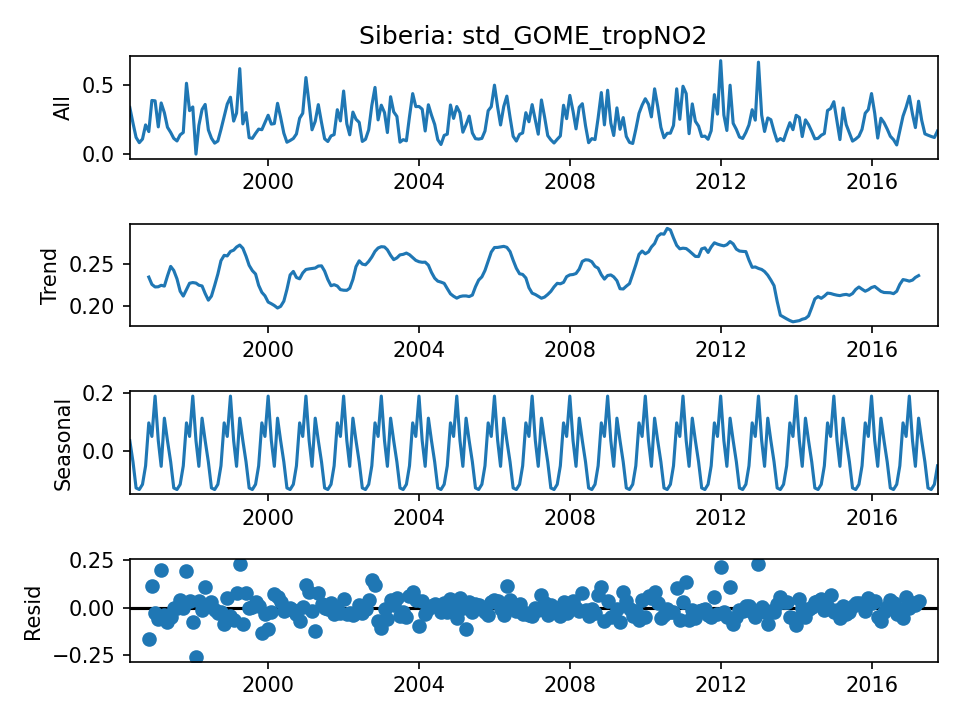

<IPython.core.display.Javascript object>


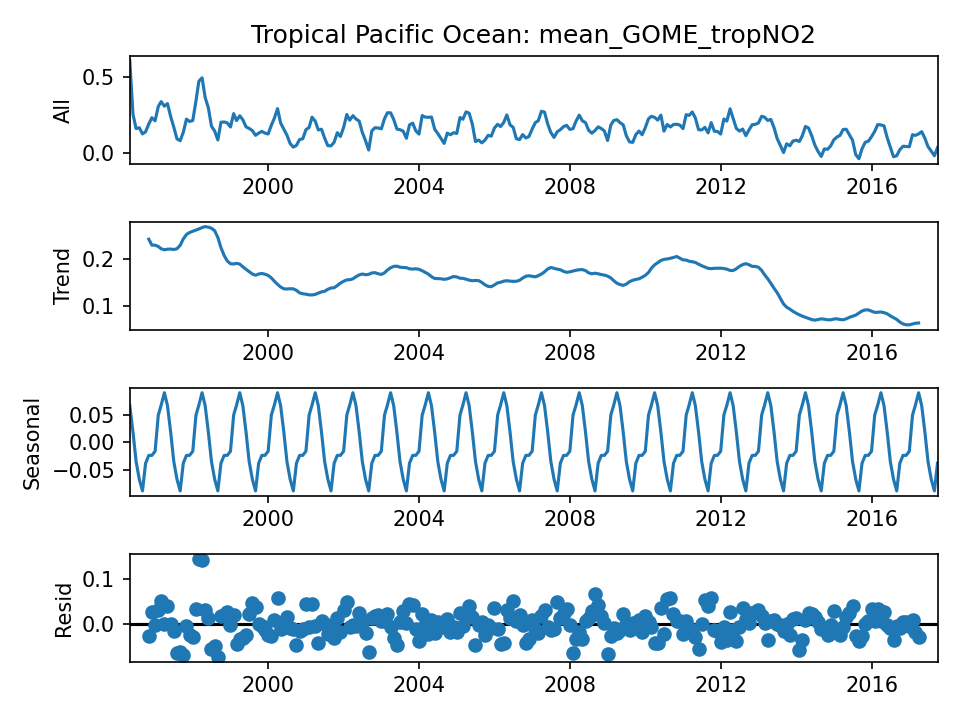

<IPython.core.display.Javascript object>


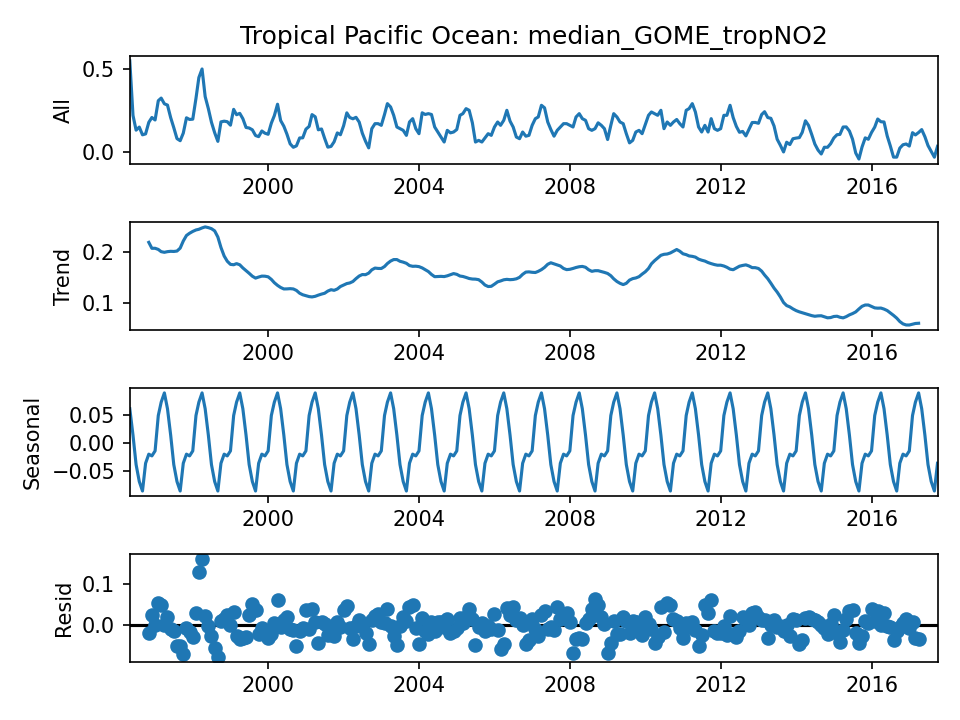

<IPython.core.display.Javascript object>


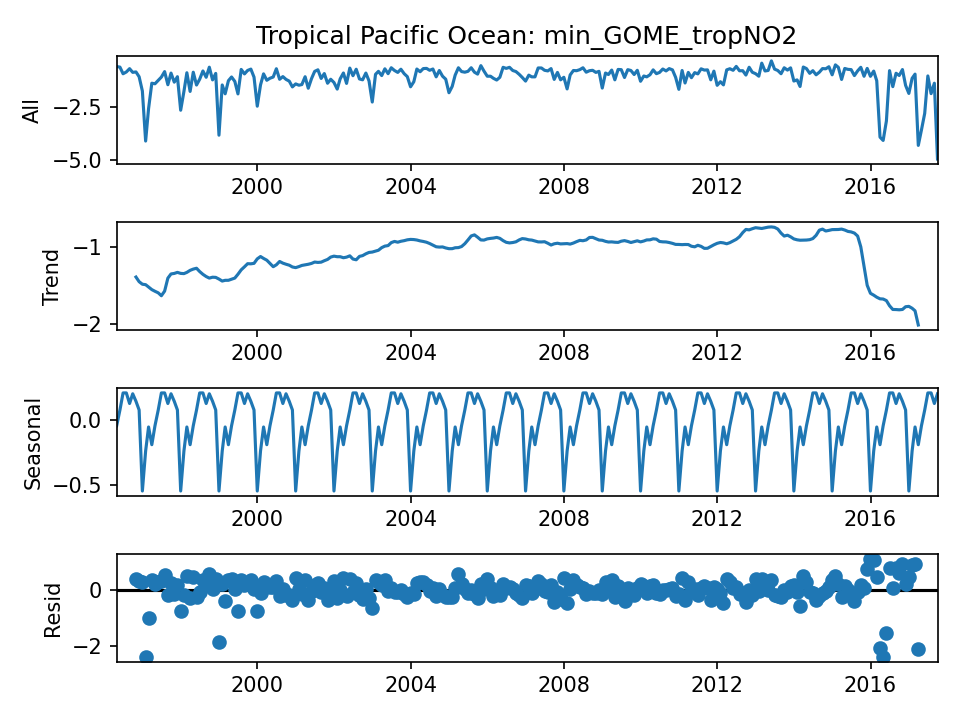

<IPython.core.display.Javascript object>


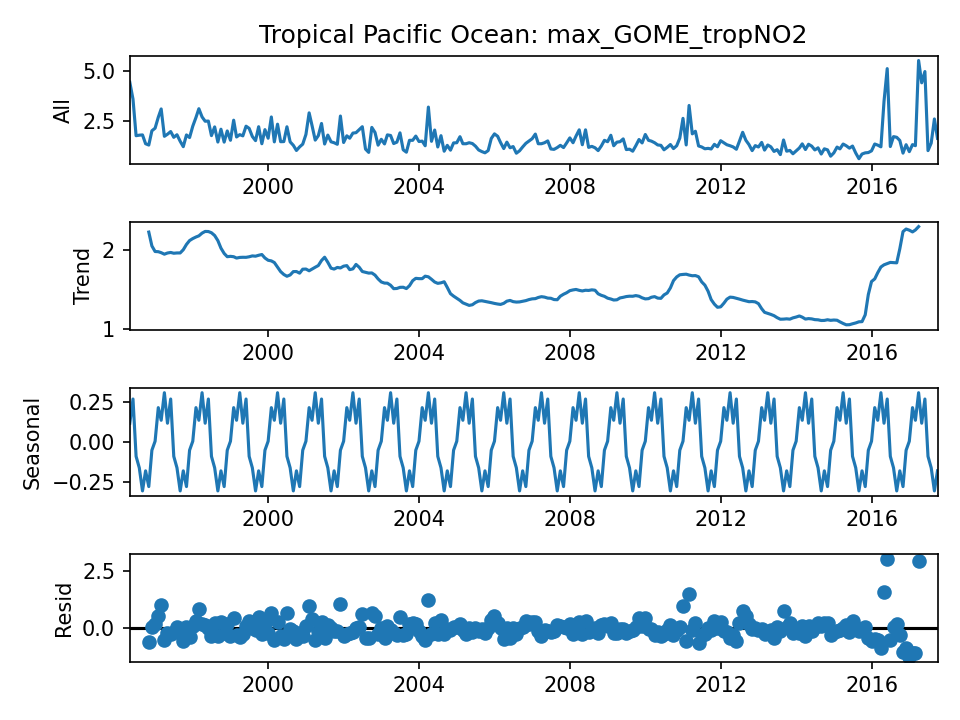

<IPython.core.display.Javascript object>


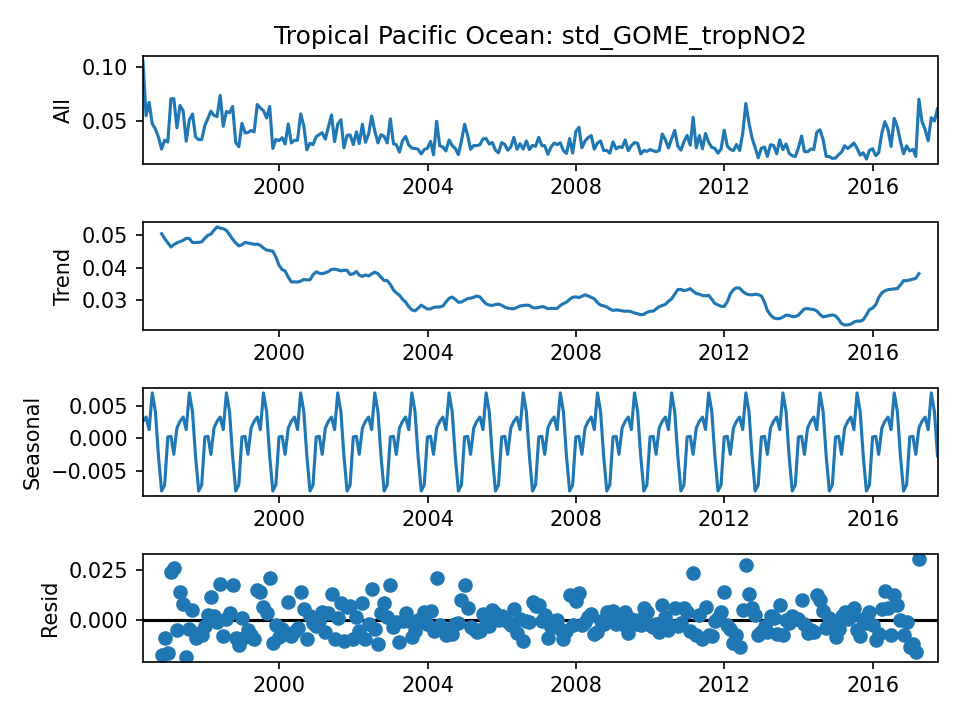

In [161]:
for rg in gome_rg:
    for typ in ['mean', 'median', 'min', 'max', 'std']:
        result_gome = seasonal_decompose(gome_rg[rg][typ][typ+'_GOME_tropNO2'])
        p = result_gome.plot()
        p.get_axes()[0].set_title(rg+ ': '+typ+'_GOME_tropNO2')
        p.get_axes()[0].set_ylabel('All')